# Predictive Maintenance mit SCANIA-Daten – Explorative Analyse

**Projekt:** Bachelorarbeit Data Science  
**Thema:** 
**Datengrundlage:** SCANIA Component X Dataset  
**Autor:** Justin Stange-Heiduk  
**Betreuung:** Dr. MArtin Prause
**Ziel:** Explorative Datenanalyse (EDA) zur Identifikation von Mustern, Ausreißern, fehlenden Werten und Datenqualität 

---

**Erstellt:** 2025-07-21  
**Letzte Änderung:** 2025-08-04


---


### Imports

In [46]:
import sys
from pathlib import Path
import importlib.util
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import random
from scipy.stats import chi2_contingency
import great_expectations as ge


In [ ]:
%run "0. CommonFunctions.ipynb"

## load raw data as dict

In [48]:
raw_data = load_raw_data()


# Anzeigen der ersten fünf Zeilen der Daten

In [49]:
for key in raw_data.keys():
    print(f"#### Key: {key} ####")
    for dataset_name, dataset in raw_data[key].items():
        print(f"Dataset: {dataset_name}, shape: {dataset.shape}")
        display(dataset.head())  # Display the first few rows of each dataset


#### Key: test ####
Dataset: labels, shape: (5045, 2)


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


Dataset: readouts, shape: (198140, 107)


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,1,4.4,94410.0,7982.0,3115020.0,2625.0,1304.0,366624.0,232040.0,147104.0,...,72548.0,9696.0,1309.0,7.0,399.0,31843.0,89138.0,24101.0,5112.0,7.0
1,1,5.0,105405.0,9178.0,3467240.0,3225.0,1305.0,390896.0,252528.0,157824.0,...,83147.0,12042.0,1841.0,7.0,455.0,35749.0,106366.0,28168.0,5420.0,7.0
2,1,8.2,214440.0,23348.0,7085790.0,8010.0,4897.0,461240.0,378264.0,313016.0,...,198090.0,26099.0,4516.0,21.0,1120.0,94017.0,293462.0,85596.0,16655.0,14.0
3,1,9.8,260190.0,29120.0,8696850.0,12525.0,6513.0,493728.0,455352.0,363984.0,...,244326.0,32708.0,5714.0,49.0,1498.0,118349.0,378176.0,115130.0,24054.0,35.0
4,1,20.6,519780.0,57967.0,17379560.0,32130.0,7617.0,665120.0,818912.0,664784.0,...,500995.0,61122.0,14247.0,169.0,3788.0,222712.0,741413.0,237274.0,59636.0,639.0


Dataset: spec, shape: (5045, 9)


,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,1,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0,Cat1
1,6,Cat0,Cat2,Cat2,Cat0,Cat0,Cat0,Cat0,Cat1
2,7,Cat0,Cat2,Cat2,Cat0,Cat0,Cat0,Cat0,Cat1
3,9,Cat0,Cat3,Cat2,Cat1,Cat0,Cat1,Cat0,Cat1
4,11,Cat0,Cat1,Cat1,Cat0,Cat0,Cat1,Cat1,Cat0


#### Key: train ####
Dataset: tte, shape: (23550, 3)


,vehicle_id,length_of_study_time_step,in_study_repair
0,0,510.0,0
1,2,281.8,0
2,3,293.4,0
3,4,210.0,0
4,5,360.4,0


Dataset: readouts, shape: (1122452, 107)


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,95728.0,15609.0,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,95729.0,15610.0,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,142900.0,19263.0,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,150565.0,19832.0,2522.0,12.0,1444.0,211688.0,318901.0,107745.0,19406.0,453.0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,155913.0,20573.0,2562.0,12.0,1445.0,213956.0,323997.0,109514.0,19535.0,454.0


Dataset: spec, shape: (23550, 9)


,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
1,2,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0,Cat1
2,3,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
3,4,Cat0,Cat0,Cat2,Cat1,Cat0,Cat0,Cat0,Cat1
4,5,Cat0,Cat2,Cat2,Cat0,Cat0,Cat0,Cat0,Cat1


#### Key: validation ####
Dataset: labels, shape: (5046, 2)


,vehicle_id,class_label
0,10,0
1,16,0
2,18,0
3,23,0
4,45,0


Dataset: readouts, shape: (196227, 107)


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,10,3.0,46590.0,3696.0,2038959.0,1450.0,0.0,273826.0,339584.0,99834.0,...,100725.0,8026.0,855.0,15.0,495.0,91665.0,169125.0,51900.0,9362.0,0.0
1,10,7.4,127110.0,16716.0,6501456.0,4660.0,0.0,635642.0,609742.0,288036.0,...,295291.0,44312.0,7995.0,75.0,2265.0,414180.0,688891.0,258810.0,63167.0,1005.0
2,10,8.0,144015.0,19596.0,7327918.0,5230.0,0.0,654780.0,665756.0,300174.0,...,335479.0,52203.0,9421.0,75.0,2415.0,487080.0,812071.0,300735.0,77477.0,1500.0
3,10,12.0,187560.0,24264.0,9286082.0,7420.0,2647.0,831628.0,794332.0,360066.0,...,463265.0,61399.0,10727.0,75.0,2610.0,655620.0,1118116.0,403516.0,99587.0,1591.0
4,10,12.2,187575.0,24264.0,9286082.0,7420.0,NaN,NaN,NaN,NaN,...,463265.0,61400.0,10727.0,75.0,2611.0,655620.0,1118116.0,403517.0,99588.0,1592.0


Dataset: spec, shape: (5046, 9)


,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,10,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1
1,16,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
2,18,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
3,23,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0
4,45,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1


### Analyse der Labels

In [50]:
tte_train_df = raw_data["train"]["tte"]
labels_test_df = raw_data["test"]["labels"]
labels_validation_df = raw_data["validation"]["labels"]



#### Verteilung der Klassen als Balkendiagram

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution_bar(label_series: pd.Series, title: str, ax=None) -> None:
    """
    Plots a horizontal bar chart showing the distribution of labels in a Pandas Series.

    Args:
        label_series (pd.Series): Series containing the labels to be plotted.
        title (str): Title of the plot.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes will be created.
    
    Results:
        None: Displays the plot.
    """
    counts = label_series.value_counts().sort_index()
    labels = counts.index
    total = len(label_series)
    percentages = counts / total * 100

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))

    palette = sns.color_palette("tab10", len(labels))

    bars = ax.barh(labels.astype(str), counts, color=palette)

    # Werte an die Balken schreiben
    for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
        ax.text(bar.get_width() + total * 0.005, bar.get_y() + bar.get_height()/2,
                f"{pct:.1f}%\n({count})",
                va='center', ha='left', fontsize=10)

    ax.set_title(title)
    ax.set_xlabel("Anzahl")
    ax.set_ylabel("Klasse")
    ax.invert_yaxis()  # Höchste Klasse oben
    sns.despine()

    plt.tight_layout()
    plt.show()


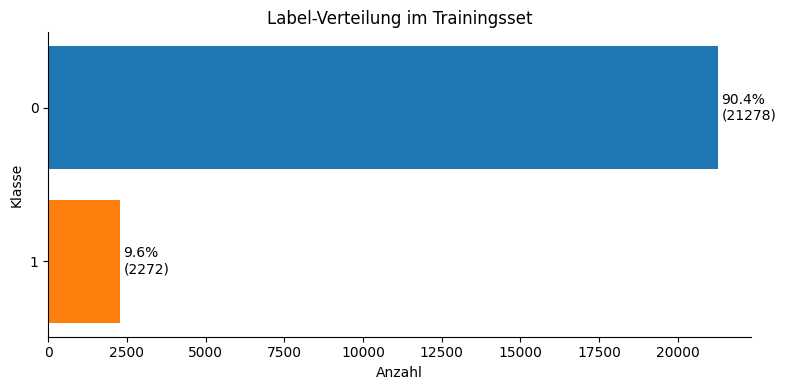

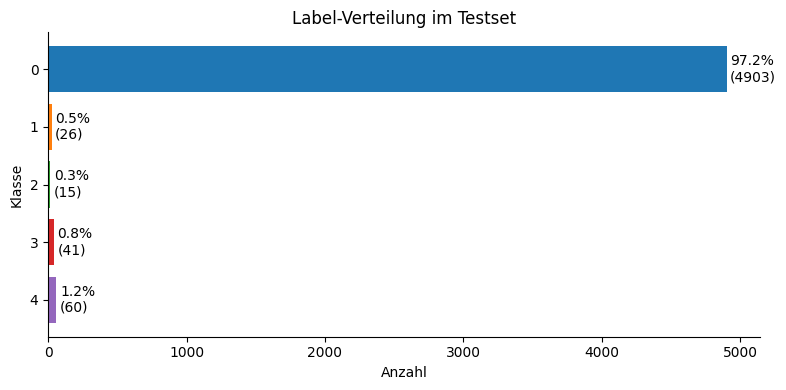

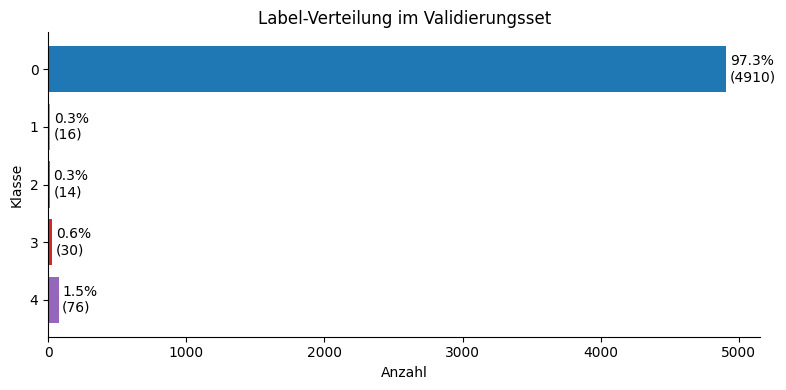

In [52]:
plot_label_distribution_bar(tte_train_df["in_study_repair"], "Label-Verteilung im Trainingsset")
plot_label_distribution_bar(labels_test_df["class_label"], "Label-Verteilung im Testset")
plot_label_distribution_bar(labels_validation_df["class_label"], "Label-Verteilung im Validierungsset")


#### Histogramm der Klassen und Anzahl der Fahrzeuge

In [53]:

def plot_observation_time_histogram(tte_df: pd.DataFrame) -> None:
    """
    Plots a histogram of observation times grouped by label (e.g., repair vs. healthy).

    Args:
        tte_df (pd.DataFrame): DataFrame containing the columns 'length_of_study_time_step' and 'in_study_repair'.

    Returns:
        None: Displays the histogram.
    """
    # Farben für Label 0 (gesund) und 1 (repariert)
    colors = {0: 'darkblue', 1: 'lightcoral'}
    
    plt.figure(figsize=(6, 4))

    # Histogramme getrennt nach Label zeichnen
    for label in sorted(tte_df["in_study_repair"].unique()):
        subset = tte_df[tte_df["in_study_repair"] == label]
        plt.hist(subset["length_of_study_time_step"], bins=150, alpha=0.8,
                 label=str(label), color=colors.get(label, 'gray'))

    plt.xlabel("Beobachtungszeit")
    plt.ylabel("Anzahl der Fahrzeuge")
    plt.title("Verteilung der Beobachtungszeit im Trainingsset")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()


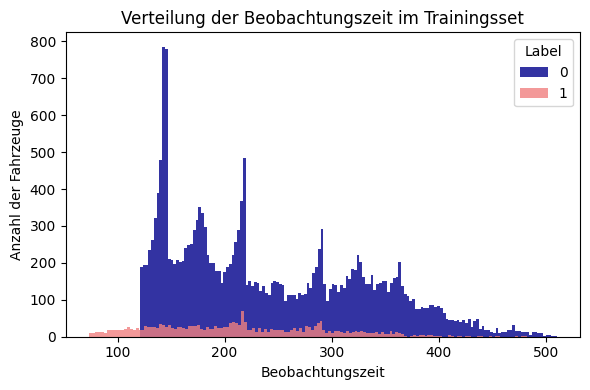

In [54]:
plot_observation_time_histogram(tte_train_df)


In [55]:
# Nur Zeilen mit Label 0 (kein Ausfall)
label_0_df = tte_train_df[tte_train_df["in_study_repair"] == 0]

# Nach Zeit sortieren und früheste 5 anzeigen
label_0_df_sorted = label_0_df.sort_values("length_of_study_time_step")
print(label_0_df_sorted.head())

       vehicle_id  length_of_study_time_step  in_study_repair
15650       22373                      121.0                0
9850        14152                      121.0                0
9277        13348                      121.0                0
18153       25940                      121.0                0
22880       32698                      121.0                0


#### Berechnung der Gini-Index und die Entropie

In [56]:
import numpy as np
from collections import Counter

def gini_index(y):
    counts = np.array(list(Counter(y).values()))
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

def entropy(y):
    counts = np.array(list(Counter(y).values()))
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))  # log2 für bessere Interpretierbarkeit

In [57]:
print("Gini (tte Train):", gini_index(tte_train_df["in_study_repair"]))
print("Entropie (tte Train):", entropy(tte_train_df["in_study_repair"]))
print("Gini (Labels Train):", gini_index(labels_test_df["class_label"]))
print("Entropie (Labels Train):", entropy(labels_test_df["class_label"]))
print("Gini (Labels Validation):", gini_index(labels_validation_df["class_label"]))
print("Entropie (Labels Validation):", entropy(labels_validation_df["class_label"]))

Gini (tte Train): 0.17433609116439253
Entropie (tte Train): 0.4577228417895695
Gini (Labels Train): 0.05525823583781653
Entropie (Labels Train): 0.23662140094920772
Gini (Labels Validation): 0.05289772460387798
Entropie (Labels Validation): 0.22336740226825713


### Analyse der Spezifikation der Fahrzeuge

In [58]:
print(raw_data["test"].keys())

dict_keys(['labels', 'readouts', 'spec'])


In [59]:
spec_train = raw_data["train"]["spec"]
spec_test = raw_data["test"]["spec"]
spec_validation = raw_data["validation"]["spec"]

In [60]:

def get_random_vehicle_per_class(df: pd.DataFrame, label_column: str) -> dict[int, str]:
    """
    Erstellt ein Dictionary, das für jede Klasse (0–4) ein zufälliges Fahrzeug (`vehicle_id`) enthält.

    Args:
        df (pd.DataFrame): DataFrame mit Klassenlabels, enthält Spalten 'vehicle_id' und 'class_label'.
        label_column (str): Name der Spalte, die die Klassenlabels enthält.
    Returns:
        dict[int, str]: Dictionary mit Klassenlabels (0–4) als Keys und jeweils einer zufälligen `vehicle_id` als Value.
    """
    result = {}
    for label in sorted(df[label_column].unique()):
        vehicle_ids = df[df[label_column] == label]['vehicle_id'].tolist()
        if vehicle_ids:
            result[label] = random.choice(vehicle_ids)
    return result


In [61]:
vehicle_dict_04 = get_random_vehicle_per_class(labels_test_df, "class_label")

print("Zufällige Fahrzeuge pro Klasse (Testset (0-4)):")
for label, vehicle_id in vehicle_dict_04.items():
    print(f"Klasse {label}: Fahrzeug {vehicle_id}")

Zufällige Fahrzeuge pro Klasse (Testset (0-4)):
Klasse 0: Fahrzeug 2583
Klasse 1: Fahrzeug 9477
Klasse 2: Fahrzeug 4448
Klasse 3: Fahrzeug 1156
Klasse 4: Fahrzeug 19000


In [62]:
vehicle_dict_01 = get_random_vehicle_per_class(tte_train_df, "in_study_repair")

print("Zufällige Fahrzeuge pro Klasse (Trainingsset (0-4)):")
for label, vehicle_id in vehicle_dict_01.items():
    print(f"Klasse {label}: Fahrzeug {vehicle_id}")

Zufällige Fahrzeuge pro Klasse (Trainingsset (0-4)):
Klasse 0: Fahrzeug 165
Klasse 1: Fahrzeug 11000


### Histogram der Spezifikation Daten

#### Histogram der Specs nach Training/Validation/Test

In [63]:
def plot_individual_spec_distributions(
    spec_train: pd.DataFrame,
    spec_val: pd.DataFrame,
    spec_test: pd.DataFrame
) -> None:
    """
    Plottet für jede Spezifikationsspalte (beginnend mit 'Spec_') ein separates Balkendiagramm
    zur Verteilung der Ausprägungen in Train, Val und Test.

    Args:
        spec_train (pd.DataFrame): Trainings-Spezifikationen.
        spec_val (pd.DataFrame): Validierungs-Spezifikationen.
        spec_test (pd.DataFrame): Test-Spezifikationen.

    Returns:
        None: Zeigt für jede 'Spec_'-Spalte einen Plot.
    """
    spec_cols = [col for col in spec_train.columns if col.startswith("Spec_")]

    for col in spec_cols:
        # Relative Häufigkeit berechnen
        train_counts = spec_train[col].value_counts(normalize=True)
        val_counts = spec_val[col].value_counts(normalize=True)
        test_counts = spec_test[col].value_counts(normalize=True)

        # Alle Kategorien, die irgendwo vorkommen
        all_categories = sorted(set(train_counts.index)
                                .union(val_counts.index)
                                .union(test_counts.index))

        x = range(len(all_categories))
        width = 0.25

        plt.figure(figsize=(10, 4))
        plt.bar(
            [i - width for i in x],
            [train_counts.get(cat, 0) for cat in all_categories],
            width=width,
            label="Train Spec",
            color="darkblue"
        )
        plt.bar(
            x,
            [val_counts.get(cat, 0) for cat in all_categories],
            width=width,
            label="Val Spec",
            color="gray"
        )
        plt.bar(
            [i + width for i in x],
            [test_counts.get(cat, 0) for cat in all_categories],
            width=width,
            label="Test Spec",
            color="firebrick"
        )

        plt.title(f"Verteilung der Spezifikation: {col}")
        plt.xlabel("Kategorie")
        plt.ylabel("Proportion")
        plt.xticks(ticks=x, labels=all_categories, rotation=45)
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        plt.show()

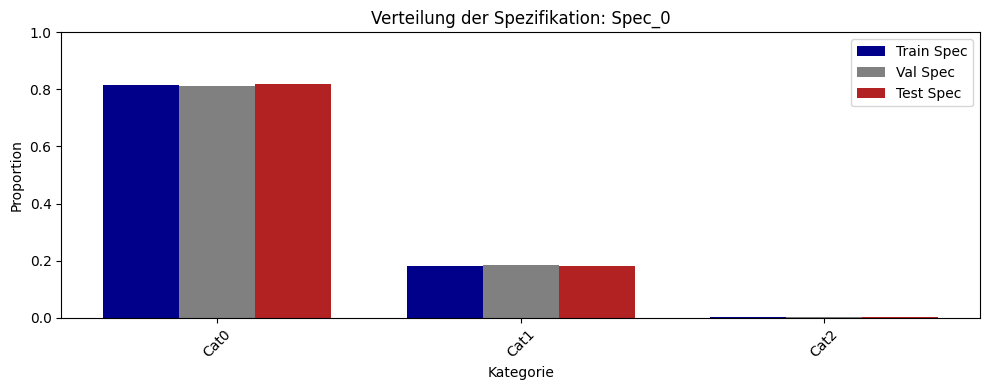

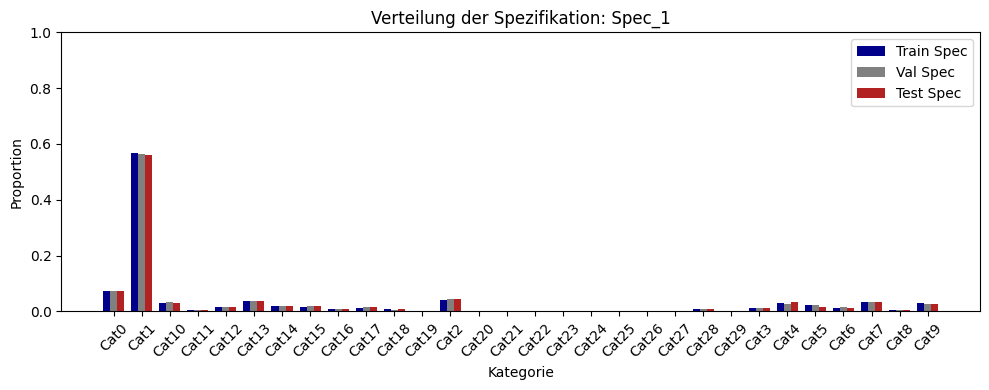

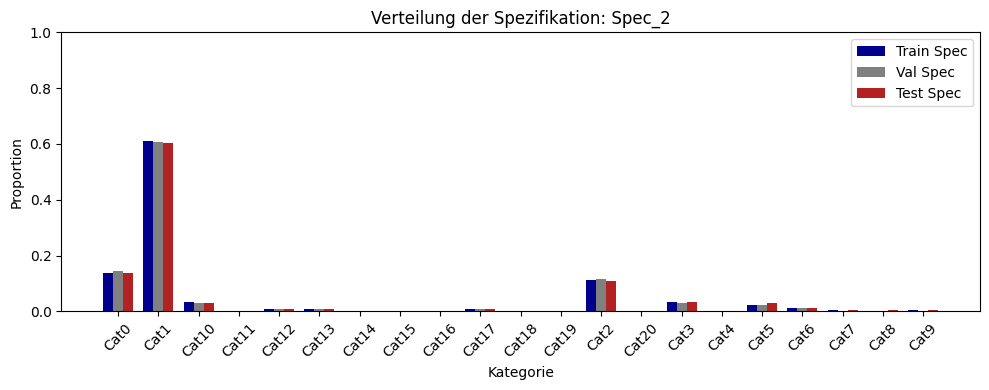

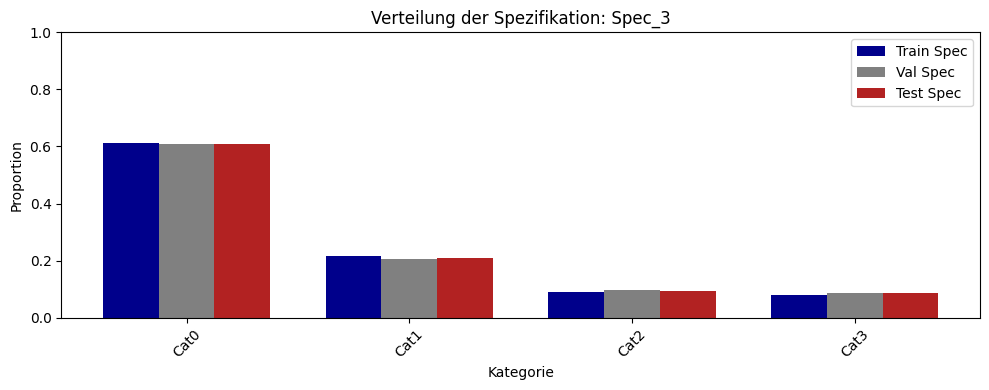

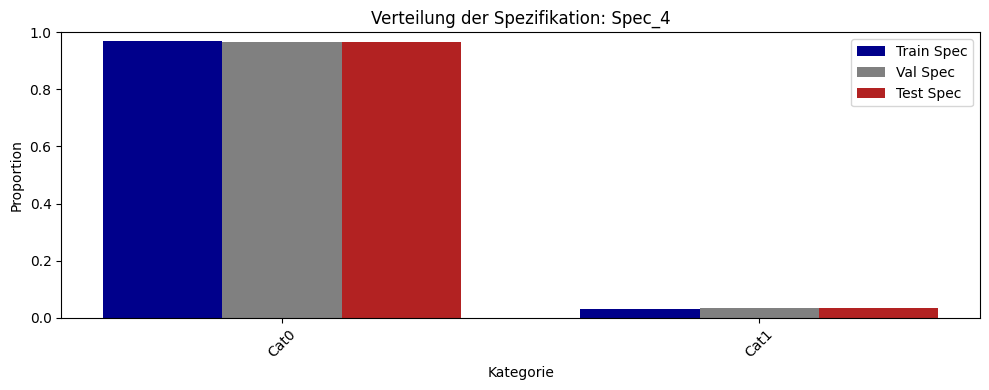

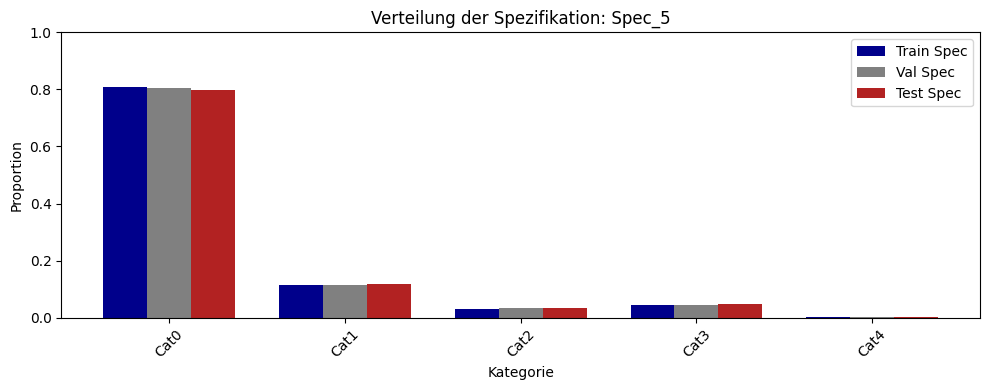

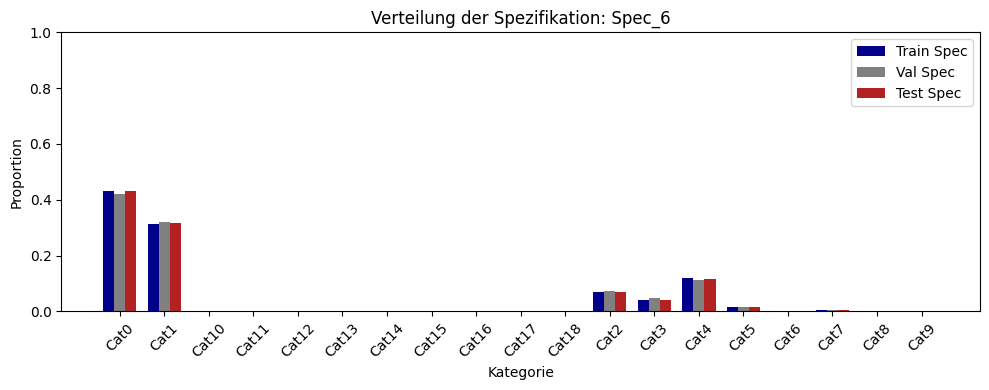

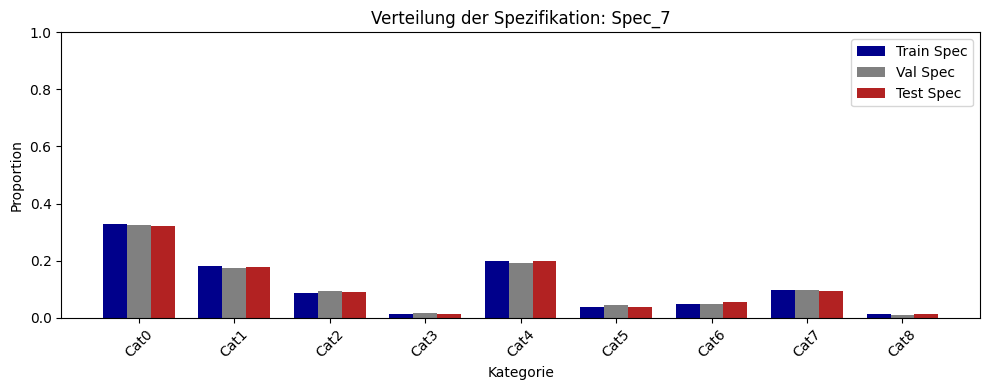

In [64]:
plot_individual_spec_distributions(
    spec_train,
    spec_validation,
    spec_test
)


#### Histogram der Specs nach Labels

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_spec_distributions_by_label(
    spec_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    label_column: str,
    Name_df: str
) -> None:
    """
    Visualisiert die Spezifikationsverteilungen (Spec_*) für beliebig viele Klassenlabels.
    Die Daten werden über 'vehicle_id' gemerged. Für jede Spezifikationsspalte wird ein
    Balkendiagramm erzeugt, das die relative Häufigkeit pro Kategorie und Label zeigt.

    Args:
        spec_df (pd.DataFrame): DataFrame mit Spezifikationsdaten (enthält vehicle_id).
        labels_df (pd.DataFrame): DataFrame mit Labels (enthält vehicle_id und Labelspalte).
        label_column (str): Name der Spalte in labels_df, die die Klassenlabels enthält.
        Name_df (str): Name des DataFrames (z.B. "Train" oder "Test").

    Returns:
        None: Zeigt für jede Spezifikationsspalte ein separates Balkendiagramm.
    """
    # Merge über vehicle_id (join inner)
    merged_df = pd.merge(spec_df, labels_df[['vehicle_id', label_column]], on='vehicle_id', how='inner')

    # Nur Spezifikationsspalten verwenden
    spec_cols = [col for col in merged_df.columns if col.startswith("Spec_")]

    # Automatische Farbcodierung nach Anzahl Labels
    unique_labels = sorted(merged_df[label_column].unique())
    num_labels = len(unique_labels)
    color_palette = plt.cm.get_cmap("tab10", num_labels)

    for col in spec_cols:
        plt.figure(figsize=(10, 4))

        # Verteilungen je Kategorie und Label
        proportions = (
            merged_df.groupby(label_column)[col]
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )

        x = range(len(proportions.columns))
        width = 0.8 / num_labels  # dynamische Balkenbreite

        for i, label in enumerate(proportions.index):
            values = proportions.loc[label].values
            plt.bar(
                [pos + (i - num_labels / 2) * width + width / 2 for pos in x],
                values,
                width=width,
                label=f"Label {label}",
                color=color_palette(i)
            )

        plt.title(f"Verteilung von {Name_df} {col} nach Label")
        plt.xlabel("Kategorie")
        plt.ylabel("Verteilung")
        plt.xticks(ticks=range(len(proportions.columns)), labels=proportions.columns, rotation=45)
        plt.ylim(0, 1)
        plt.legend(title="Label")
        plt.tight_layout()
        plt.show()


C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\3279925041.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap("tab10", num_labels)


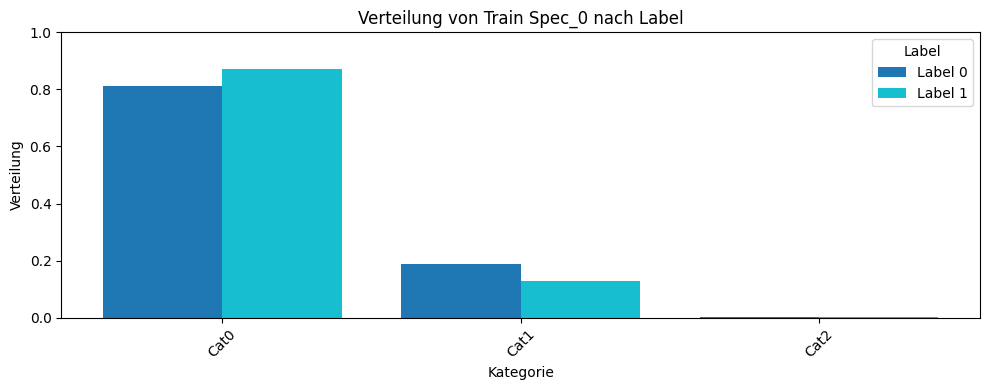

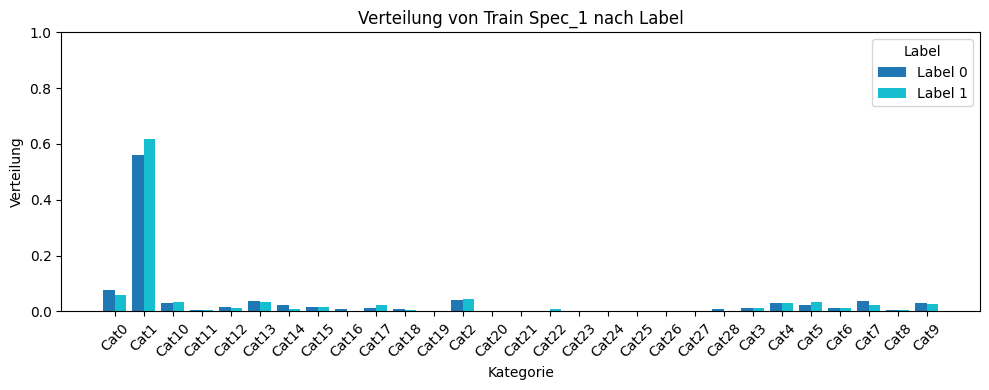

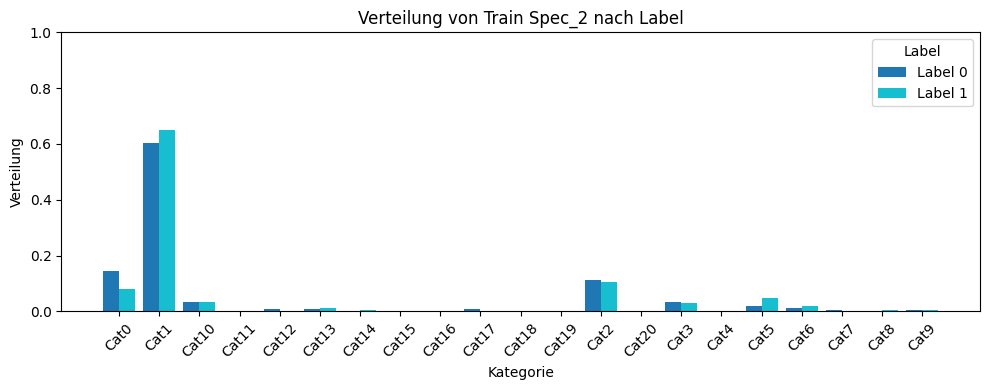

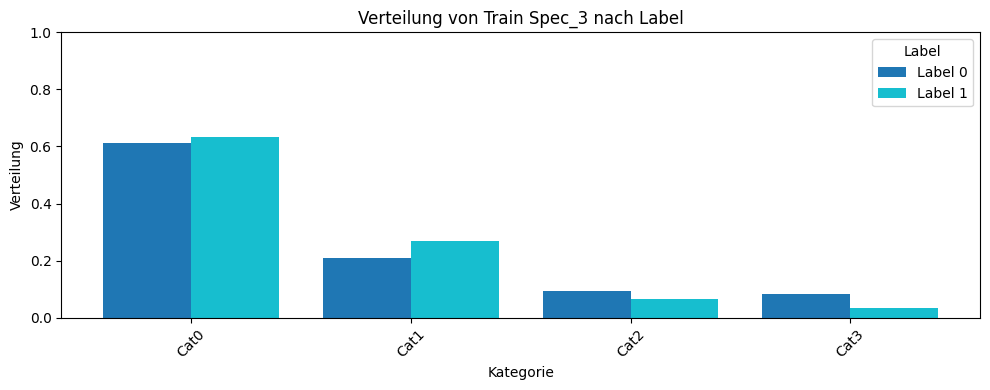

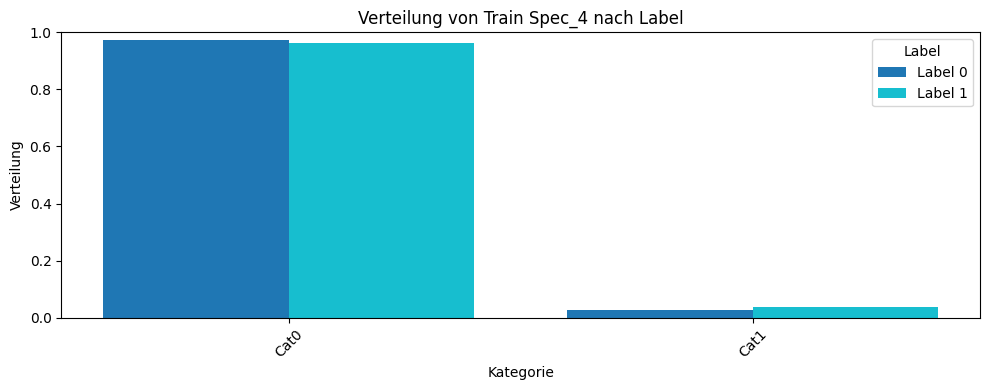

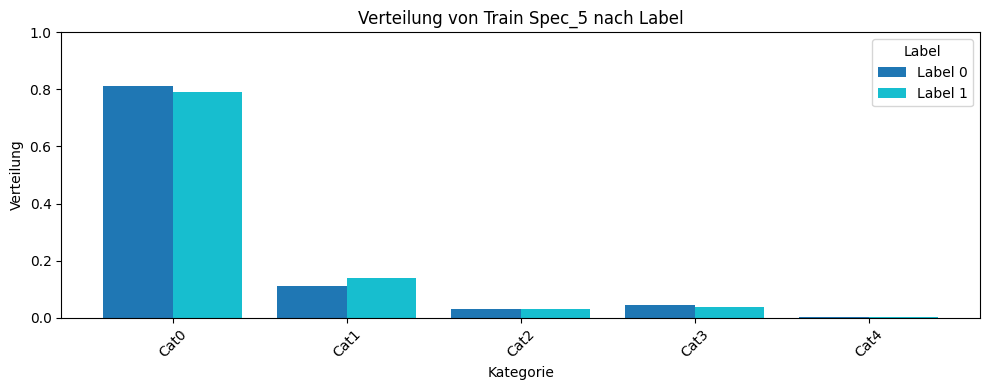

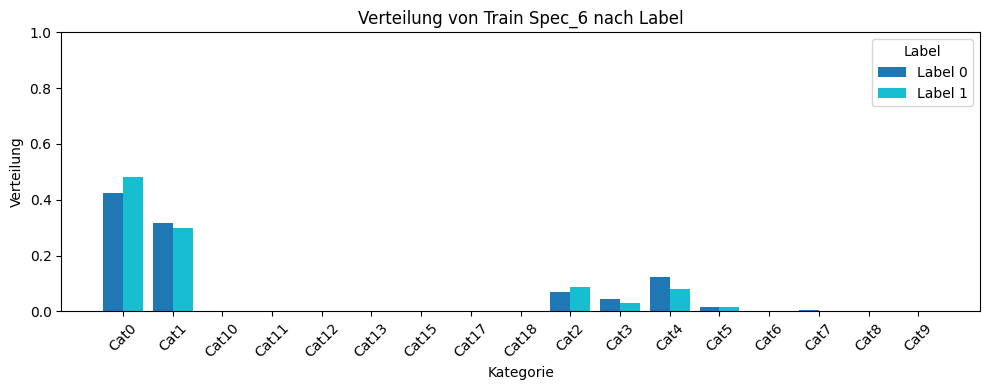

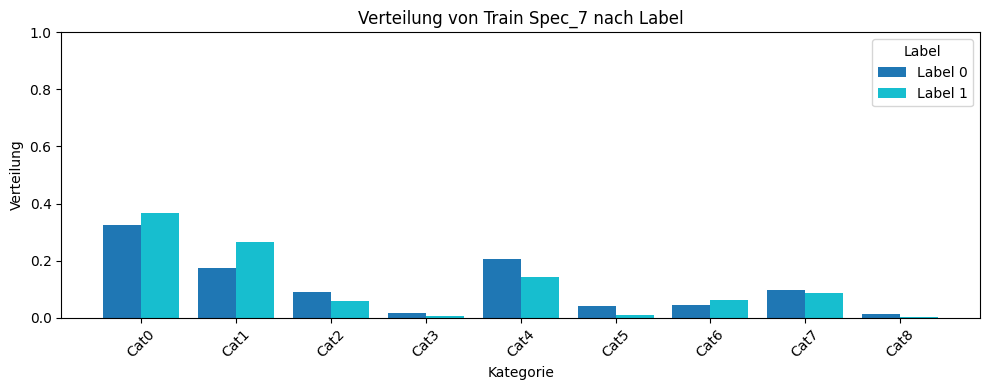

In [66]:
plot_spec_distributions_by_label(
    spec_train,
    tte_train_df,
    label_column="in_study_repair",
    Name_df = "Train"
)


In [67]:
#test und Validation Spec und Label daten zusammenführen
test_validation_labels = pd.concat([labels_test_df, labels_validation_df], ignore_index=True)
test_validation_spec = pd.concat([spec_test, spec_validation], ignore_index=True)

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\3279925041.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap("tab10", num_labels)


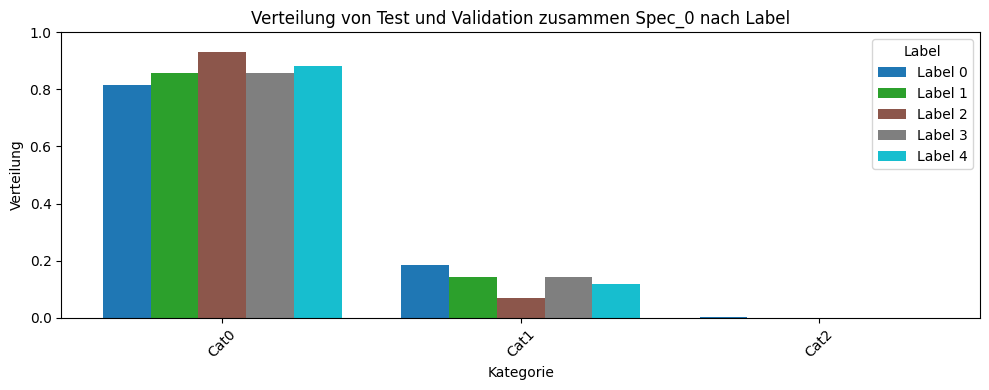

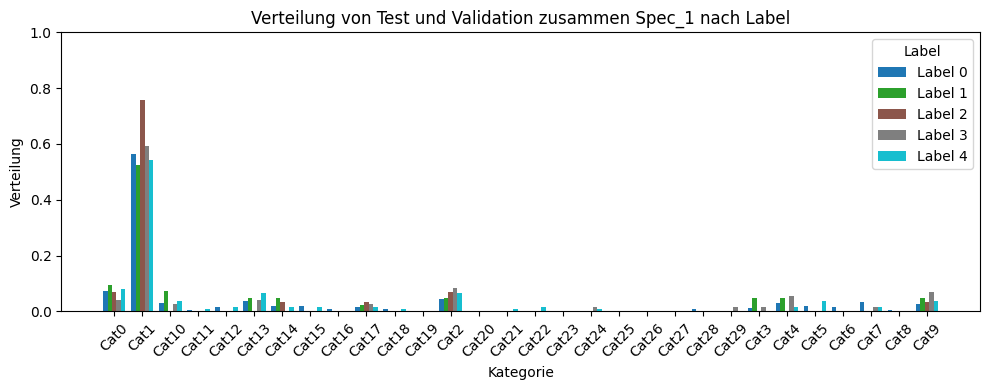

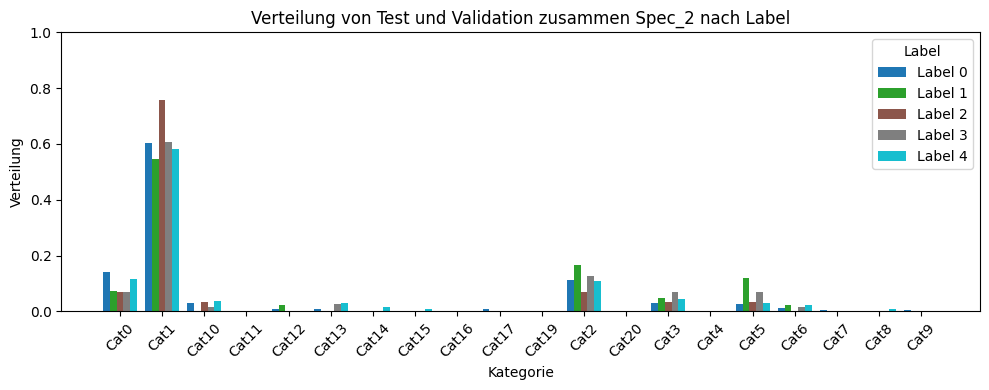

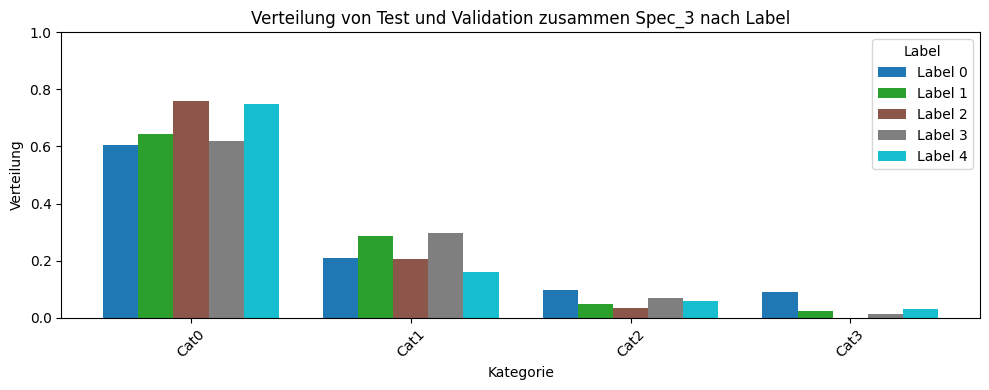

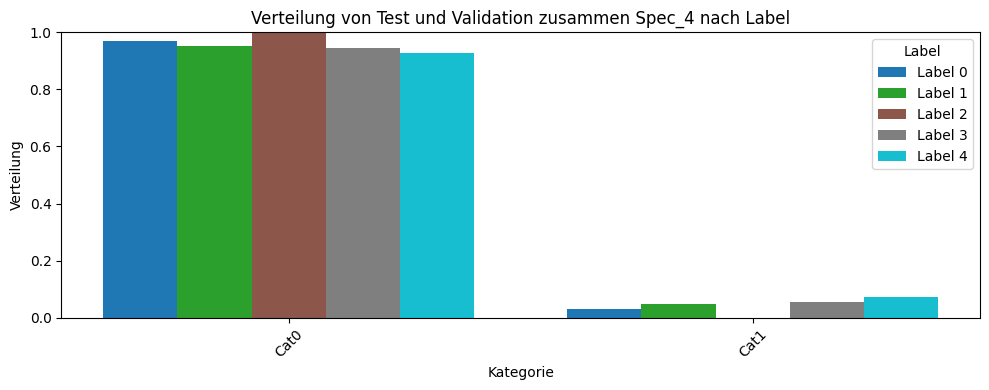

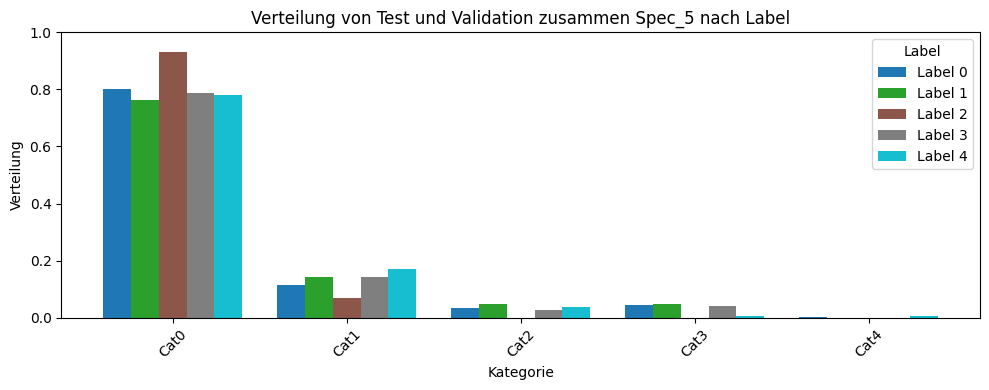

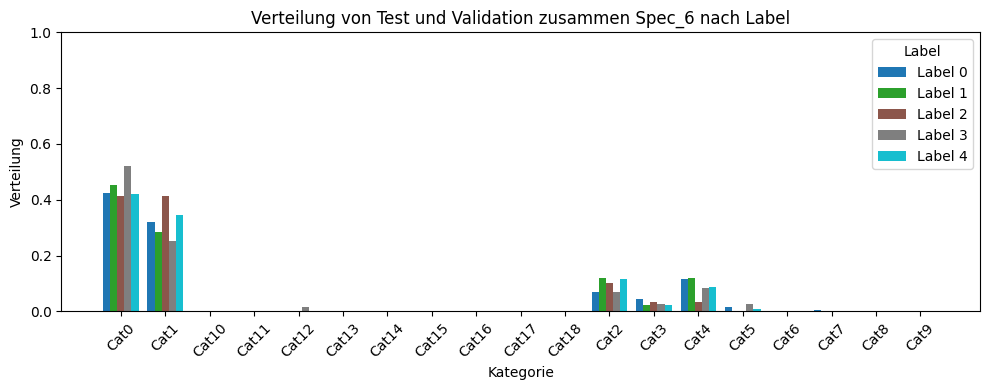

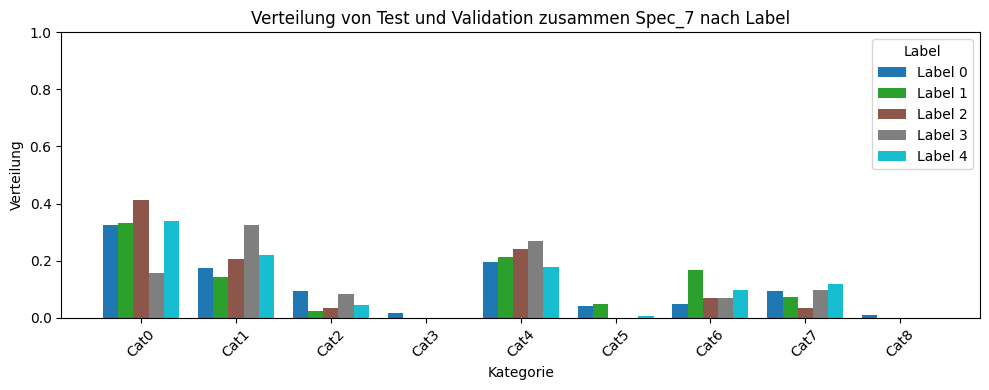

In [68]:
plot_spec_distributions_by_label(
    test_validation_spec,
    test_validation_labels,
    label_column="class_label",
    Name_df = "Test und Validation zusammen"
)

#### Berechnung des Cramér’s V

In [69]:

def cramers_v(confusion_matrix: pd.DataFrame) -> float:
    """
    Berechnet Cramér's V für eine gegebene Kontingenztabelle.
    
    Args:
        confusion_matrix (pd.DataFrame): Kreuztabelle (z. B. aus pd.crosstab).
    
    Returns:
        float: Cramér’s V Wert (Effektstärke).
    """
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def interpret_cramers_v(value: float) -> str:
    """
    Gibt eine sprachliche Interpretation für Cramér’s V zurück.
    
    Args:
        value (float): Cramér’s V Wert.
    
    Returns:
        str: Interpretation.
    """
    if value < 0.1:
        return "kein oder sehr schwacher Zusammenhang"
    elif value < 0.3:
        return "schwacher Zusammenhang"
    elif value < 0.5:
        return "mittlerer Zusammenhang"
    else:
        return "starker Zusammenhang"

def analyze_cramers_v_with_significance(
    df: pd.DataFrame, 
    labels_df: pd.DataFrame, 
    label_column: str,
    data_name: str,
    variable_id: str
) -> None:
    """
    Führt Chi²-Test und Cramér’s V Analyse für alle Spec_* Spalten durch.
    Nur signifikante Ergebnisse werden interpretiert.

    Args:
        df (pd.DataFrame): DataFrame mit Spec_* Spalten und vehicle_id.
        labels_df (pd.DataFrame): DataFrame mit Zielspalte und vehicle_id.
        label_column (str): Name der Zielspalte (z. B. 'class_label').
        data_name (str): Name des Datensatzes ('spec' oder 'readout').
        variable_id (str): ID der Variable, die für 'readout' verwendet wird (z. B. 'Spec_1').
    
    Returns:
        None: Gibt Testergebnisse aus.
    """
    
    merged_df = pd.merge(df, labels_df[['vehicle_id', label_column]], on='vehicle_id', how='inner')

    if data_name == "spec":
        spec_cols = [col for col in merged_df.columns if col.startswith("Spec_")]
    elif data_name == "readout":
        spec_cols = [col for col in merged_df.columns if col.startswith(f"{variable_id}_")]
    else:
        raise ValueError("Ungültiger data_name. Erlaubt sind 'spec' oder 'readout'.")
    for col in spec_cols:
        contingency = pd.crosstab(merged_df[col], merged_df[label_column])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, _, _ = chi2_contingency(contingency)
            if p < 0.05:
                value = cramers_v(contingency)
                interpretation = interpret_cramers_v(value)
                print(f"{col}: p = {p:.10f} → signifikanter Zusammenhang")
                print(f"\tCramér’s V = {value:.4f} → {interpretation}")
            else:
                print(f"{col}: p = {p:.10f} → kein signifikanter Zusammenhang")
        else:
            print(f"{col}: Nicht berechenbar (zu wenig Variation)")


##### Für die Trainings Daten

In [70]:
analyze_cramers_v_with_significance(
    df=spec_train,
    labels_df=tte_train_df,
    label_column="in_study_repair",
    data_name="spec",
    variable_id=None  # Hier None, da keine Readout-Analyse durchgeführt wird
)


Spec_0: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0446 → kein oder sehr schwacher Zusammenhang
Spec_1: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0745 → kein oder sehr schwacher Zusammenhang
Spec_2: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0894 → kein oder sehr schwacher Zusammenhang
Spec_3: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0690 → kein oder sehr schwacher Zusammenhang
Spec_4: p = 0.0215140493 → signifikanter Zusammenhang
	Cramér’s V = 0.0135 → kein oder sehr schwacher Zusammenhang
Spec_5: p = 0.0004863268 → signifikanter Zusammenhang
	Cramér’s V = 0.0261 → kein oder sehr schwacher Zusammenhang
Spec_6: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0535 → kein oder sehr schwacher Zusammenhang
Spec_7: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.1063 → schwacher Zusammenhang


##### Für die Test und Validierungsdaten zusammen

In [71]:
analyze_cramers_v_with_significance(
    df=test_validation_spec,
    labels_df=test_validation_labels,
    label_column="class_label",
    data_name="spec",
    variable_id=None  # Hier None, da keine Readout-Analyse durchgeführt wird
)

Spec_0: p = 0.3849101096 → kein signifikanter Zusammenhang
Spec_1: p = 0.0000000000 → signifikanter Zusammenhang
	Cramér’s V = 0.0621 → kein oder sehr schwacher Zusammenhang
Spec_2: p = 0.5304743781 → kein signifikanter Zusammenhang
Spec_3: p = 0.0027306887 → signifikanter Zusammenhang
	Cramér’s V = 0.0244 → kein oder sehr schwacher Zusammenhang
Spec_4: p = 0.0392220357 → signifikanter Zusammenhang
	Cramér’s V = 0.0245 → kein oder sehr schwacher Zusammenhang
Spec_5: p = 0.6101256429 → kein signifikanter Zusammenhang
Spec_6: p = 0.9999088490 → kein signifikanter Zusammenhang
Spec_7: p = 0.0008363742 → signifikanter Zusammenhang
	Cramér’s V = 0.0278 → kein oder sehr schwacher Zusammenhang


### Analyse der Readout Daten

In [72]:
readouts_test = raw_data["test"]["readouts"]
readouts_validation = raw_data["validation"]["readouts"]
readouts_train = raw_data["train"]["readouts"]

#### Histogram der readout Daten 

##### Histograme aus den Histogram Daten

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_variable_bin_proportions_per_label(
    df_readouts: pd.DataFrame,
    df_labels: pd.DataFrame,
    variable_id: int,
    label_column: str = "class_label",
    title_prefix: str = "Test"
) -> None:
    """
    Plottet die **relative Verteilung** der Histogramm-Bins einer Variable, gruppiert nach Label (0–4).

    Args:
        df_readouts (pd.DataFrame): DataFrame mit Histogramm-Daten (z. B. 167_0 bis 167_9).
        df_labels (pd.DataFrame): DataFrame mit Labels (enthält vehicle_id und Klassenlabel).
        variable_id (int): Die zu analysierende Variable (z. B. 167).
        label_column (str): Spaltenname für das Label.
        title_prefix (str): Zusätzlicher Titeltext (z. B. "Train" oder "Test").

    Returns:
        None
    """
    # Join über vehicle_id
    merged_df = pd.merge(df_readouts, df_labels[['vehicle_id', label_column]], on='vehicle_id', how='inner')

    # Bin-Spalten der Variable
    bin_cols = [col for col in merged_df.columns if col.startswith(f"{variable_id}_")]
    if not bin_cols:
        print(f"Keine Bins für Variable {variable_id} gefunden.")
        return

    # Gruppieren: pro Label → Mittelwert (normiert auf 1)
    grouped = merged_df.groupby(label_column)[bin_cols].sum()

    # Pro Label: normieren auf Summe 1 (Verteilung)
    proportions = grouped.div(grouped.sum(axis=1), axis=0)

    # Plot
    plt.figure(figsize=(12, 6))
    x = range(len(bin_cols))
    num_labels = len(proportions)
    bar_width = 0.8 / num_labels
    colors = plt.cm.get_cmap("tab10", num_labels)

    for i, label in enumerate(proportions.index):
        values = proportions.loc[label].values
        positions = [xi + (i - num_labels / 2) * bar_width + bar_width / 2 for xi in x]
        plt.bar(
            positions,
            values,
            width=bar_width,
            label=f"Label {label}",
            color=colors(i)
        )

    plt.xticks(ticks=range(len(bin_cols)), labels=bin_cols, rotation=45)
    plt.xlabel("Bins der Variable")
    plt.ylabel("Relative Verteilung (pro Klasse normiert)")
    plt.title(f"{title_prefix}: Verteilung von Variable {variable_id} nach Label")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()


##### Für Trainings Daten

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


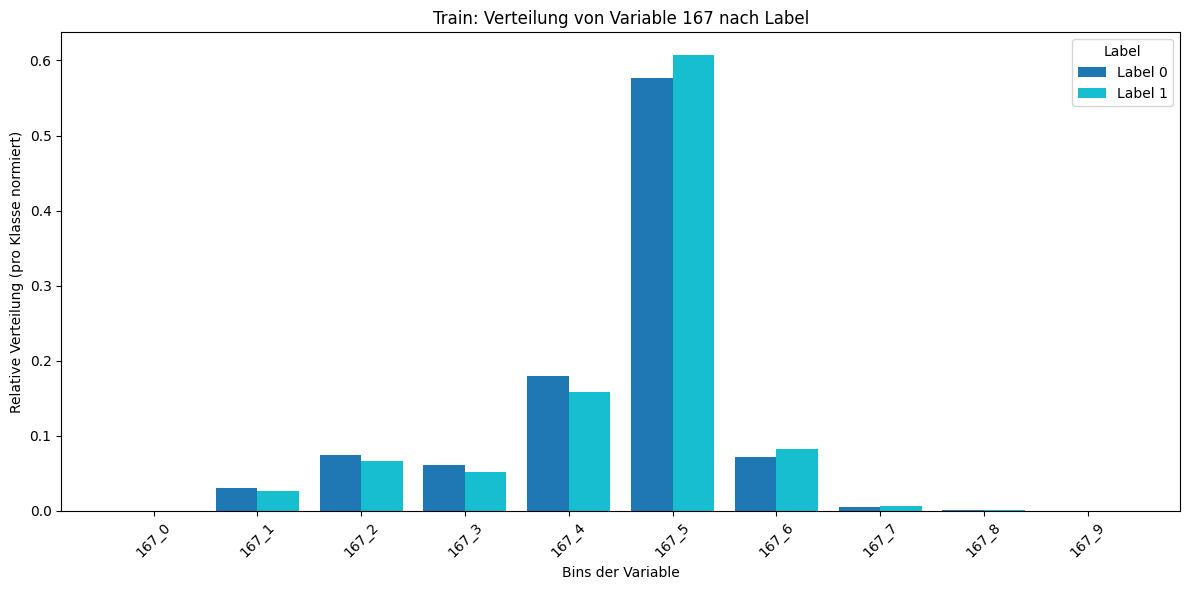

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


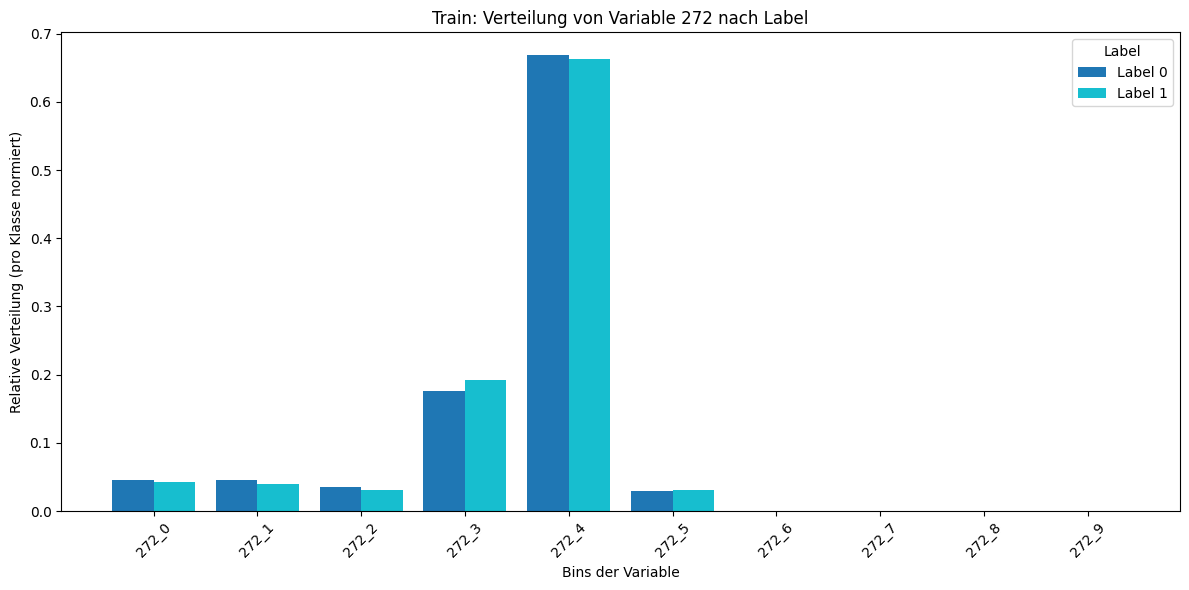

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


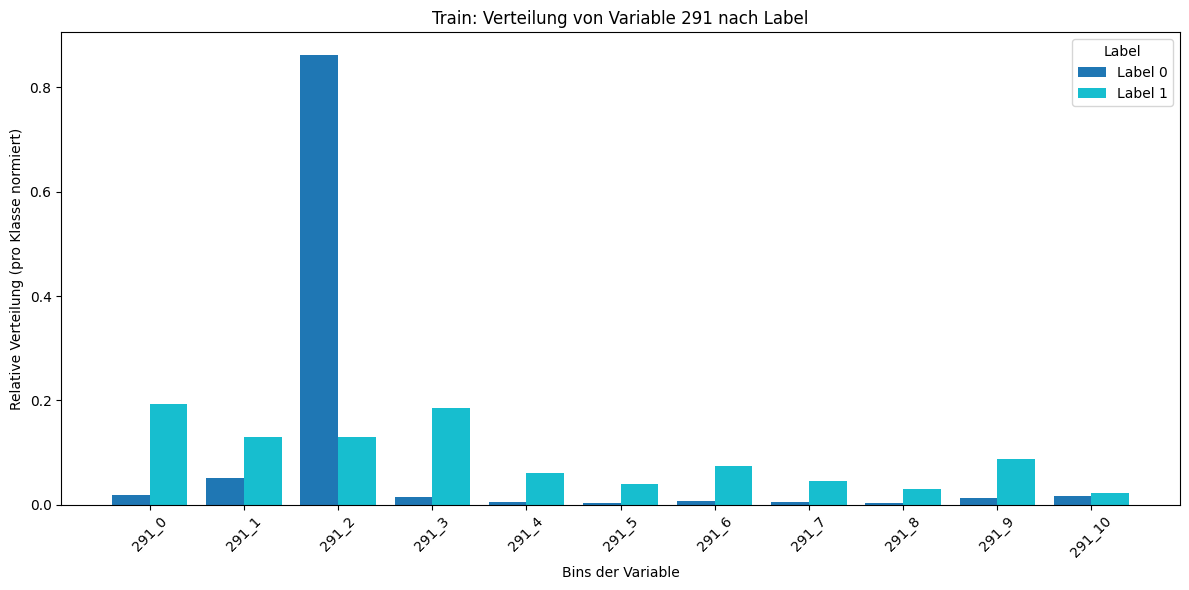

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


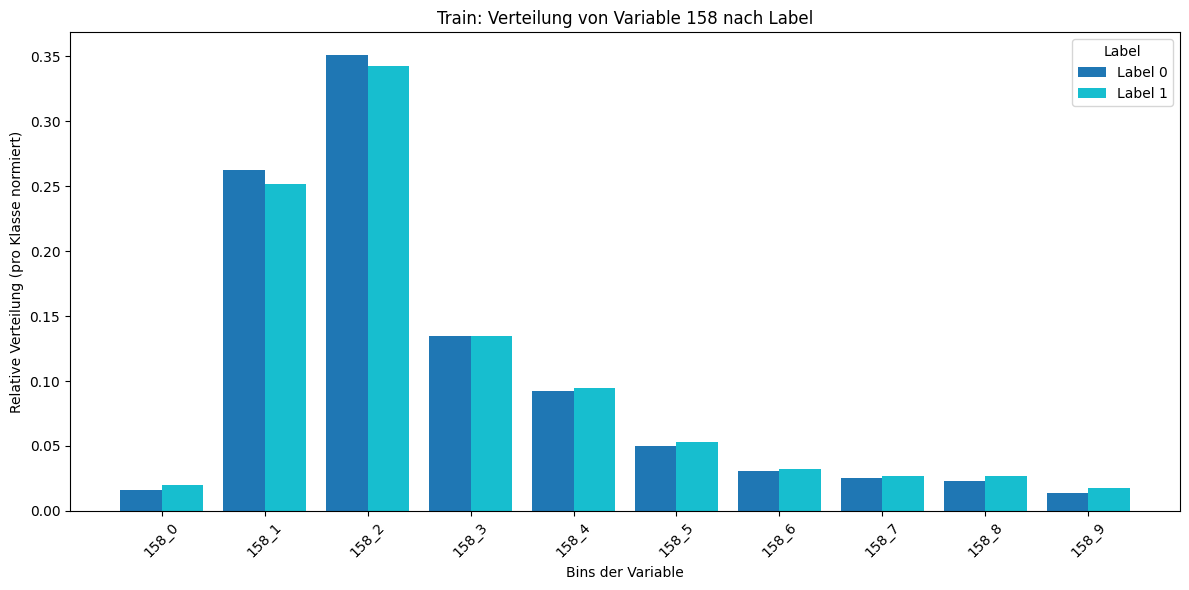

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


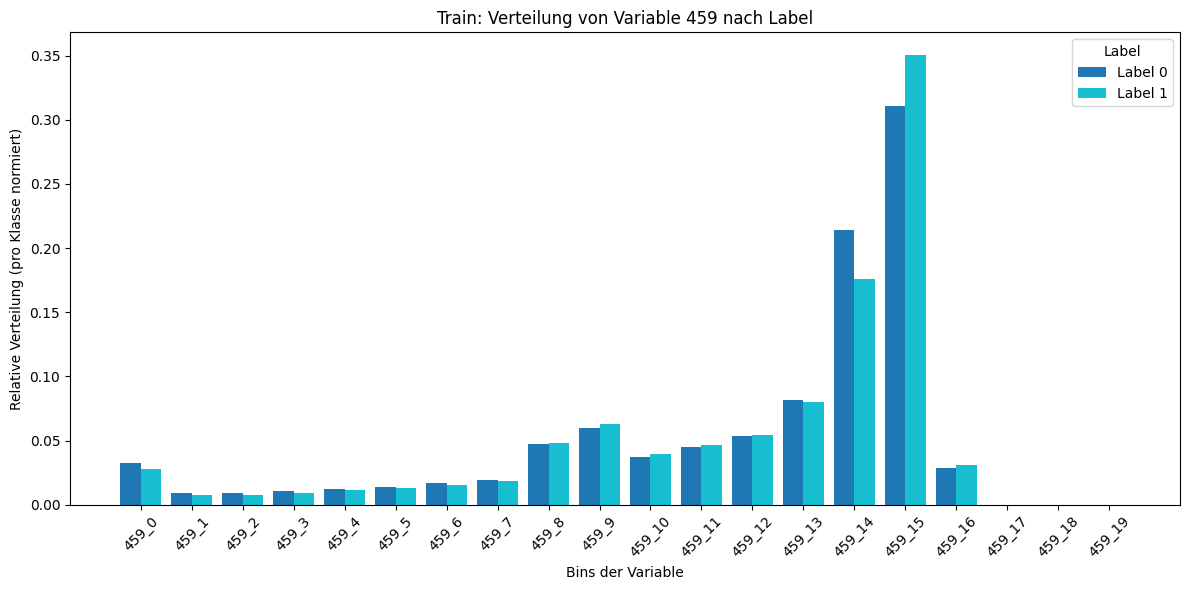

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


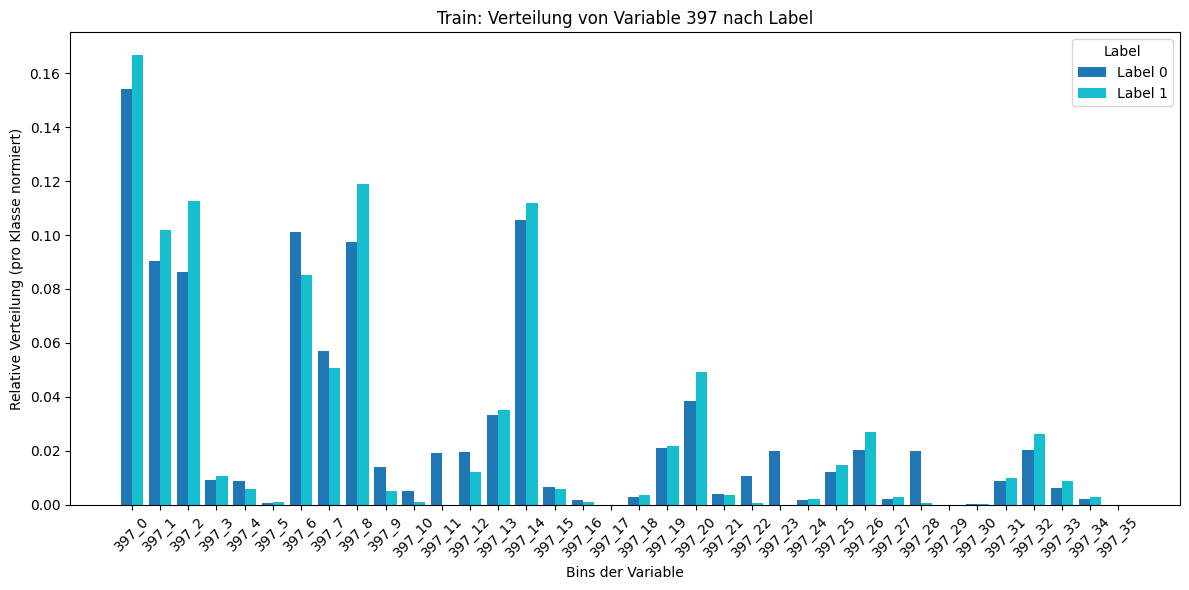

In [74]:
histogram_data_columns = [167, 272, 291, 158, 459, 397]

for variable_id in histogram_data_columns:
    plot_variable_bin_proportions_per_label(
        df_readouts=readouts_train,
        df_labels=tte_train_df,
        variable_id=variable_id,
    label_column="in_study_repair",
    title_prefix="Train"
)


##### Für Test und Validierungs Daten zusammen

In [75]:
test_validation_readout = pd.concat([readouts_test, readouts_validation], ignore_index=True)

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


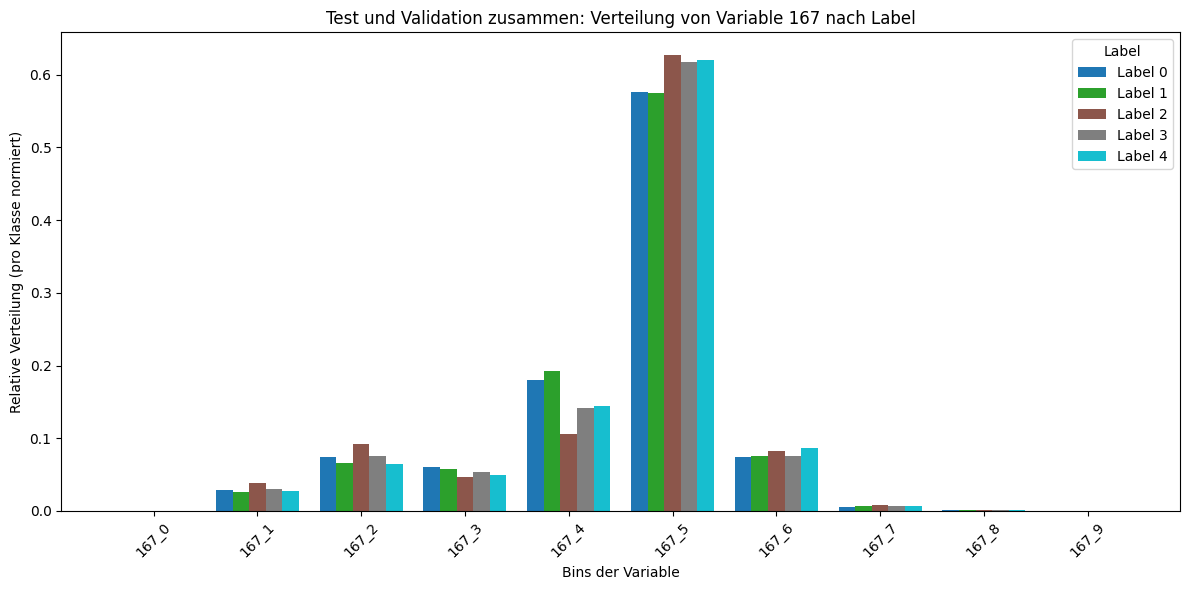

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


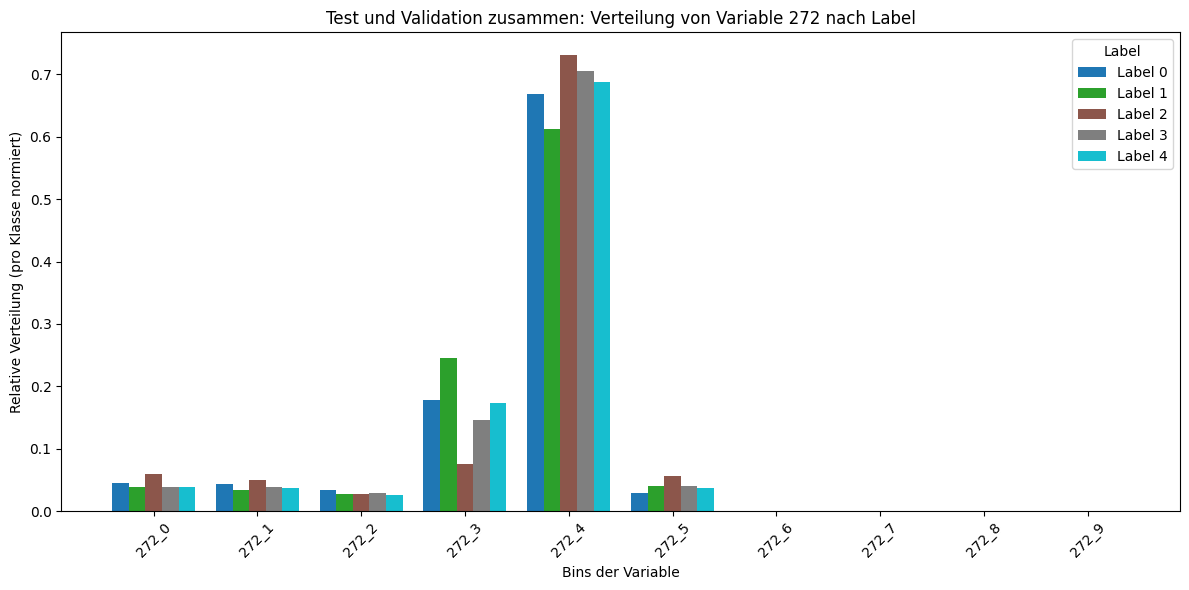

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


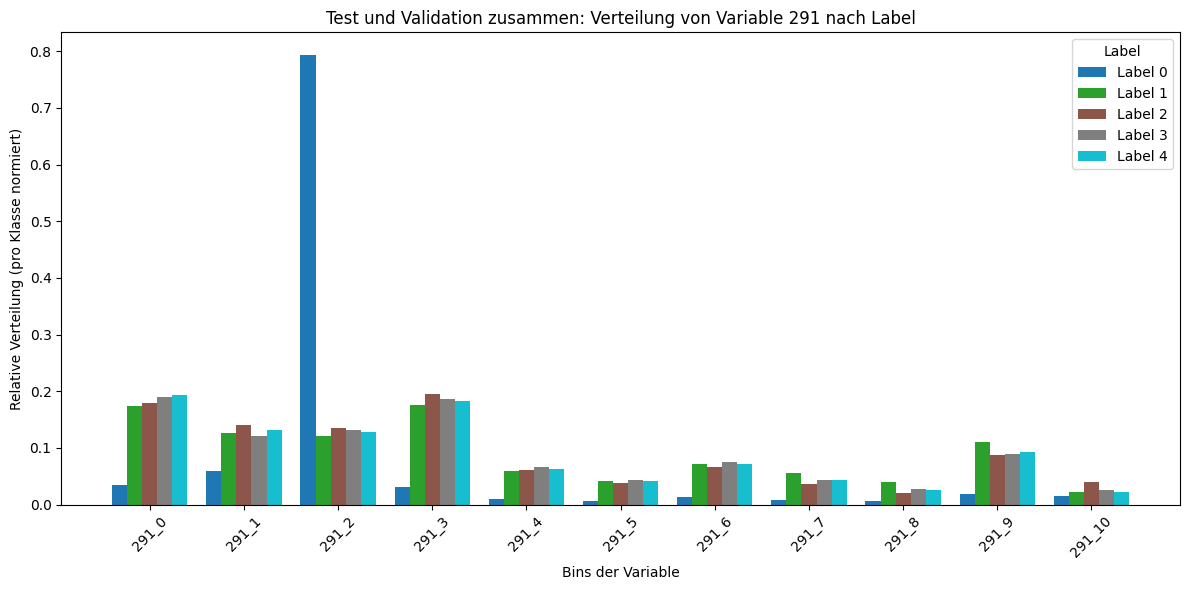

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


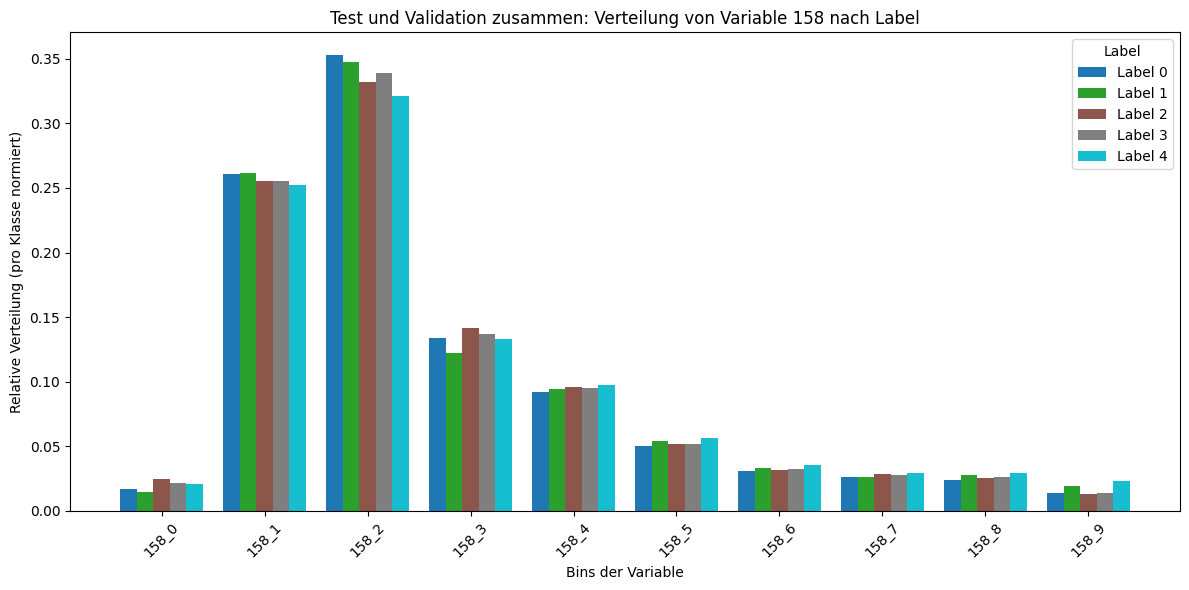

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


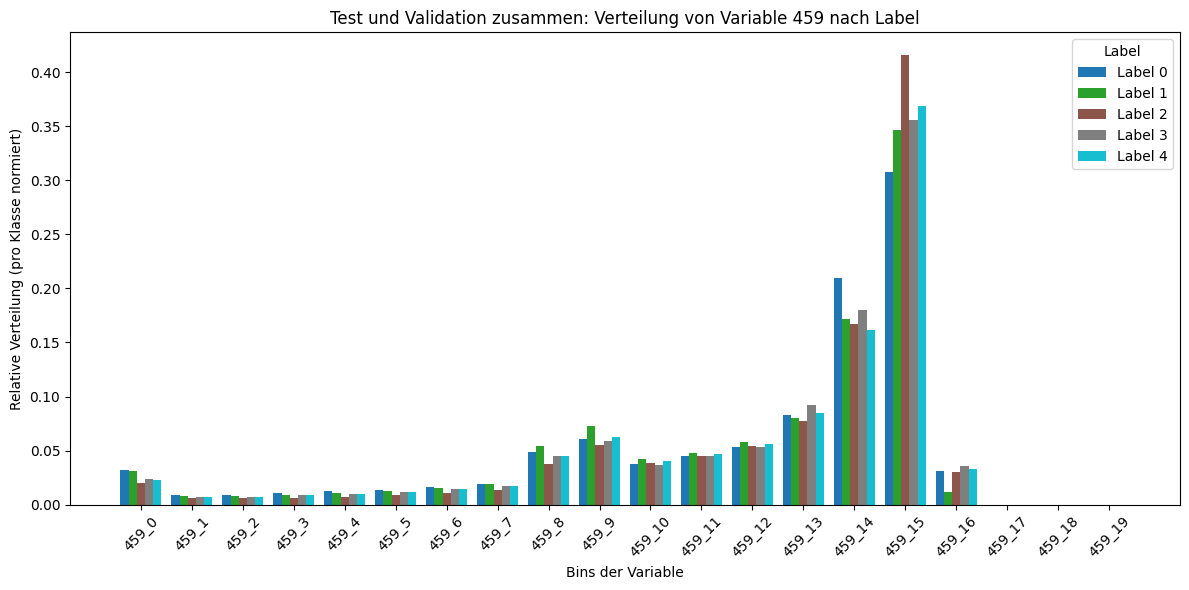

C:\Users\Justi\AppData\Local\Temp\ipykernel_94728\317666274.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)


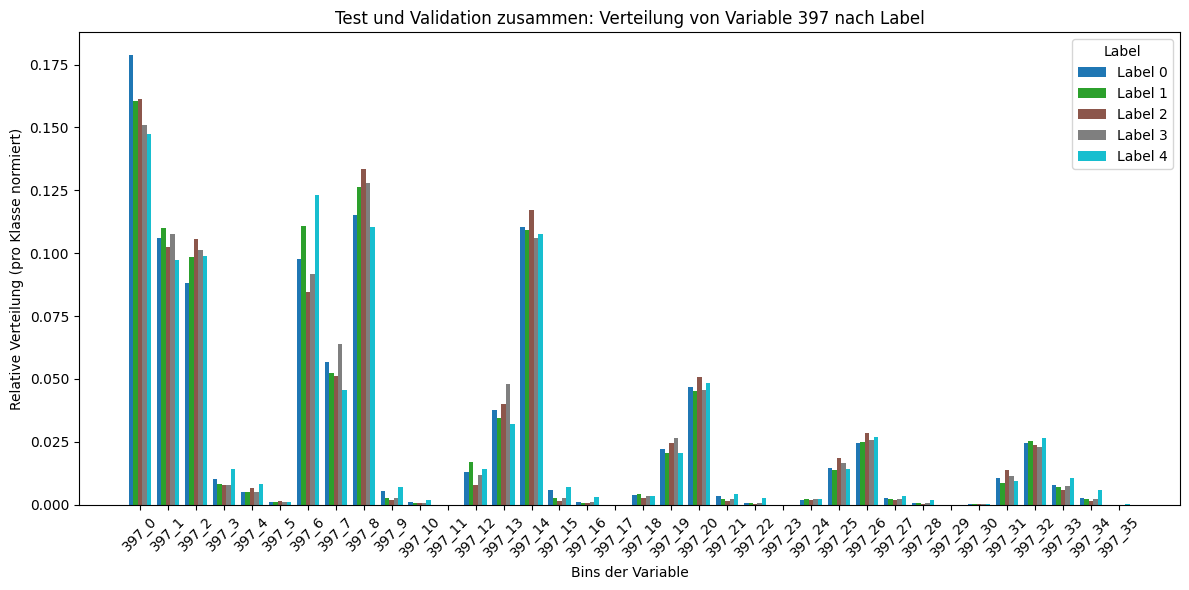

In [76]:
for variable_id in histogram_data_columns:
    plot_variable_bin_proportions_per_label(
        df_readouts=test_validation_readout,
        df_labels=test_validation_labels,
        variable_id=variable_id,
    label_column="class_label",
    title_prefix="Test und Validation zusammen"
)

##### Zeitverlauf

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histogram_feature_bins_over_time(
    readout_df: pd.DataFrame,
    label_df: pd.DataFrame,
    variable_id: str,
    label_column: str = "in_study_repair",
    min_valid_points: int = 100
) -> None:
    """
    Plots histogram bins of a specific feature over time for one vehicle from each label class.

    Args:
        readout_df (pd.DataFrame): DataFrame containing histogram features with 'vehicle_id' and 'time_step'.
        label_df (pd.DataFrame): DataFrame containing label info with 'vehicle_id' and the class label column.
        variable_id (str): ID of the histogram variable (e.g., "459", "397").
        label_column (str): Name of the column in label_df with class labels (default: "in_study_repair").
        min_valid_points (int): Minimum number of valid time points (default: 3).

    Returns:
        None. Displays one plot per class if valid data exists.
    """
    # Merge DataFrames on vehicle_id
    merged_df = pd.merge(readout_df, label_df[['vehicle_id', label_column]], on='vehicle_id', how='inner')

    # Alle Bin-Spalten für das gegebene Variable ID finden (z. B. "167_0", "167_1", ...)
    bin_cols = [col for col in merged_df.columns if col.startswith(f"{variable_id}_")]
    if not bin_cols:
        print(f"Keine Bins für Variable {variable_id} gefunden.")
        return

    # Für jede Klasse (z. B. 0 und 1) ein Beispiel-Fahrzeug plotten
    for label in sorted(merged_df[label_column].dropna().unique()):
        # Fahrzeug suchen, das genügend nicht-NaNs und Zeitpunkte hat
        valid_vehicle_id = None
        for vid in merged_df[merged_df[label_column] == label]["vehicle_id"].unique():
            vehicle_data = merged_df[merged_df["vehicle_id"] == vid]
            if vehicle_data[bin_cols].notna().sum().sum() >= min_valid_points and vehicle_data["time_step"].nunique() >= min_valid_points:
                valid_vehicle_id = vid
                break

        if valid_vehicle_id is None:
            print(f"Kein gültiges Fahrzeug für Feature {variable_id} und Label {label} gefunden.")
            continue

        # Fahrzeugdaten sortieren und anzeigen
        vehicle_data = merged_df[merged_df["vehicle_id"] == valid_vehicle_id].sort_values("time_step")

        # Plot
        plt.figure(figsize=(12, 6))
        for bin_col in bin_cols:
            valid_points = vehicle_data[["time_step", bin_col]].dropna()
            if valid_points.empty:
                continue
            plt.plot(
                valid_points["time_step"],
                valid_points[bin_col],
                marker="o",
                label=bin_col
            )

        plt.title(f"Histogram Feature 12 {variable_id} Bins – Vehicle {valid_vehicle_id} (Label {label})")
        plt.xlabel("Time Step")
        plt.ylabel("Bin Values")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()



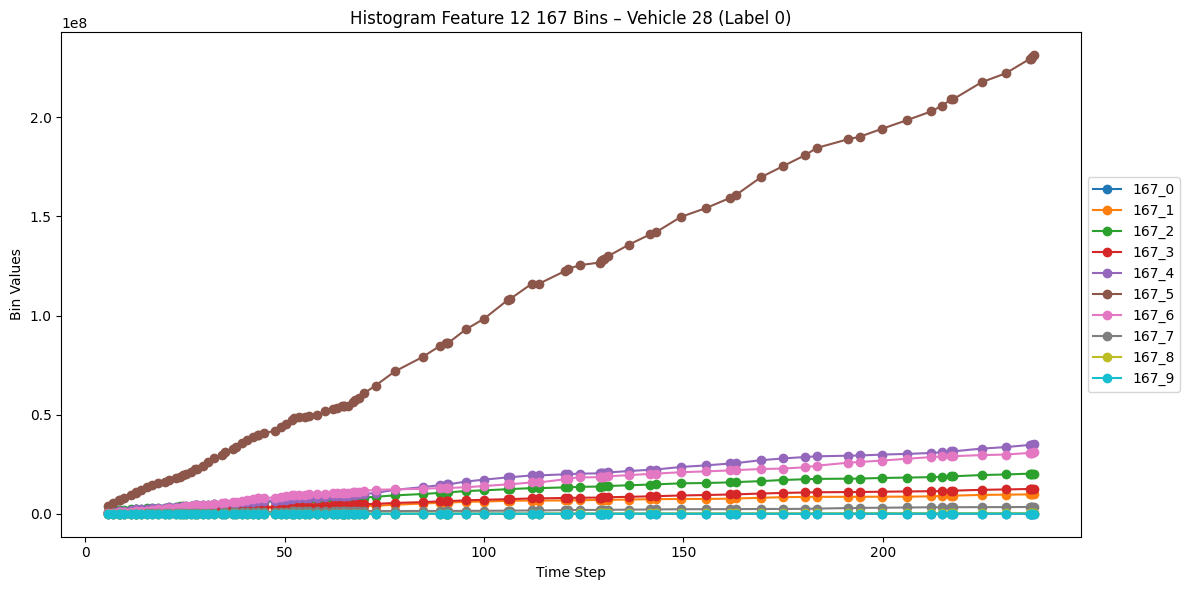

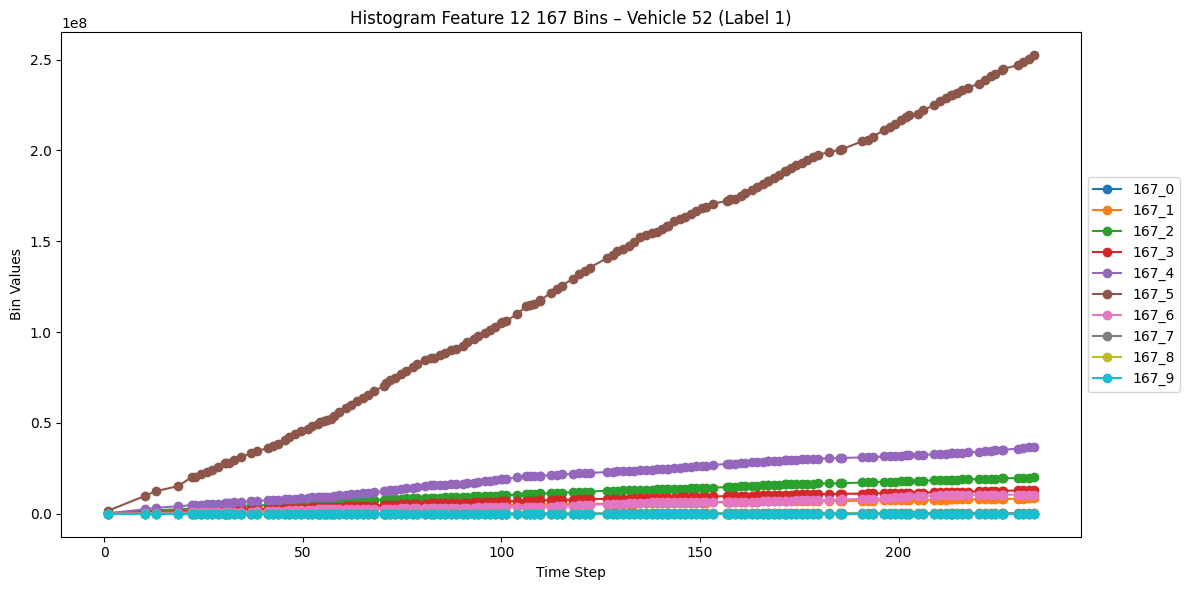

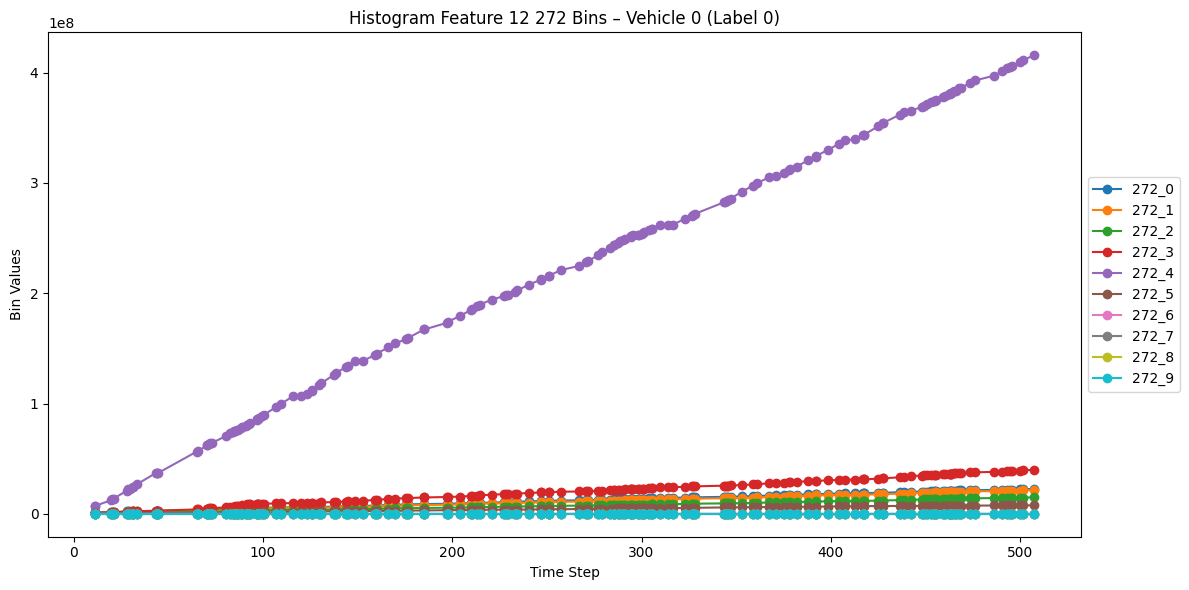

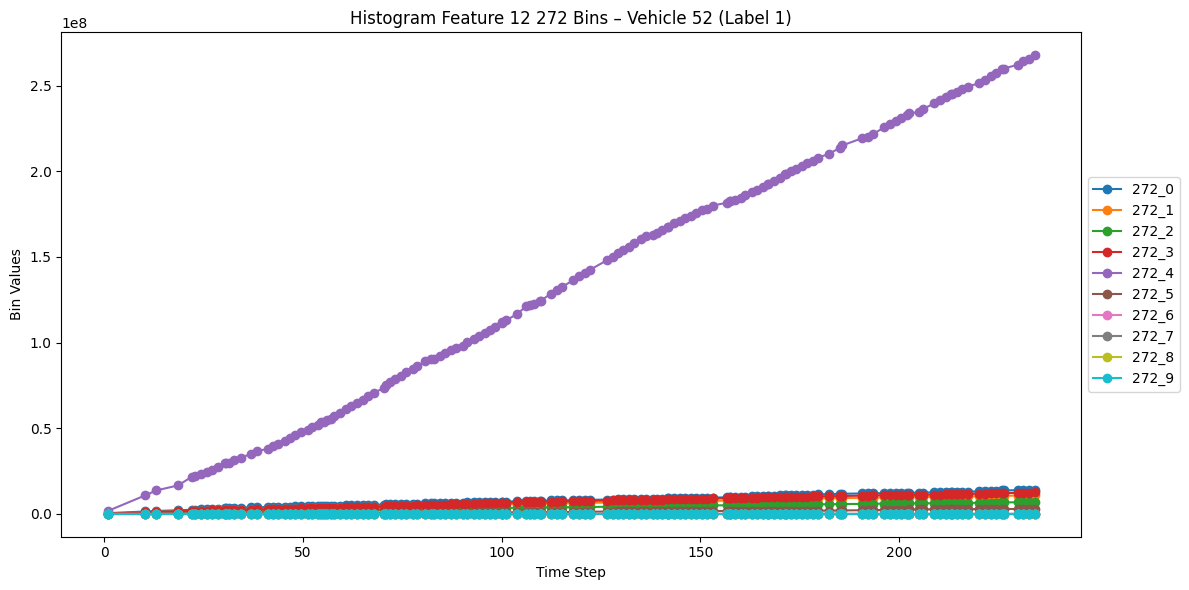

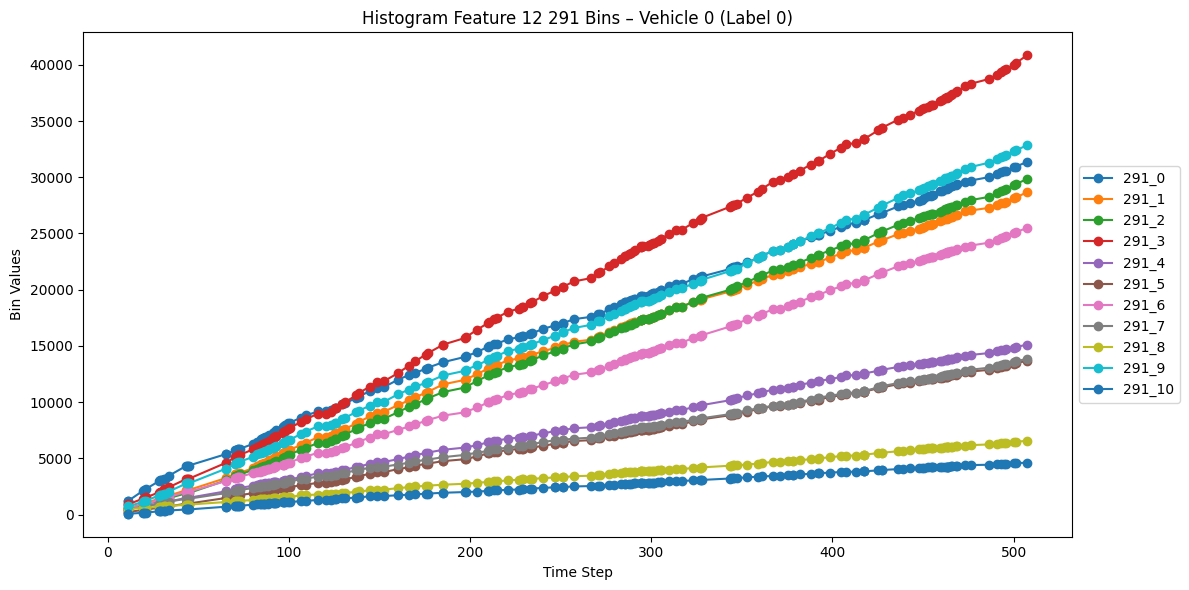

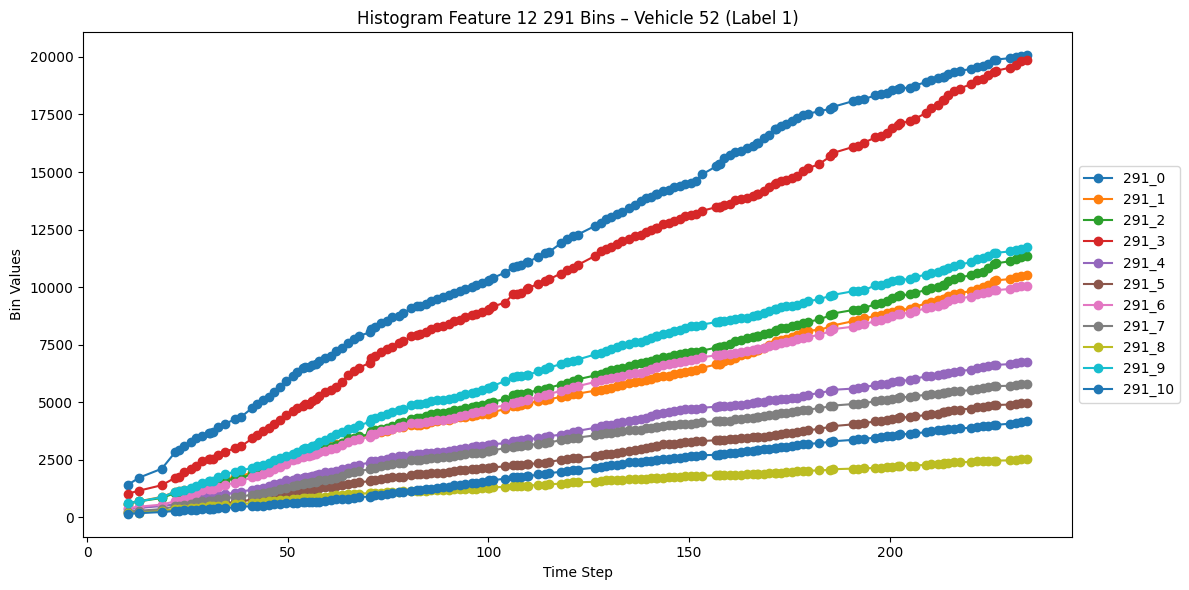

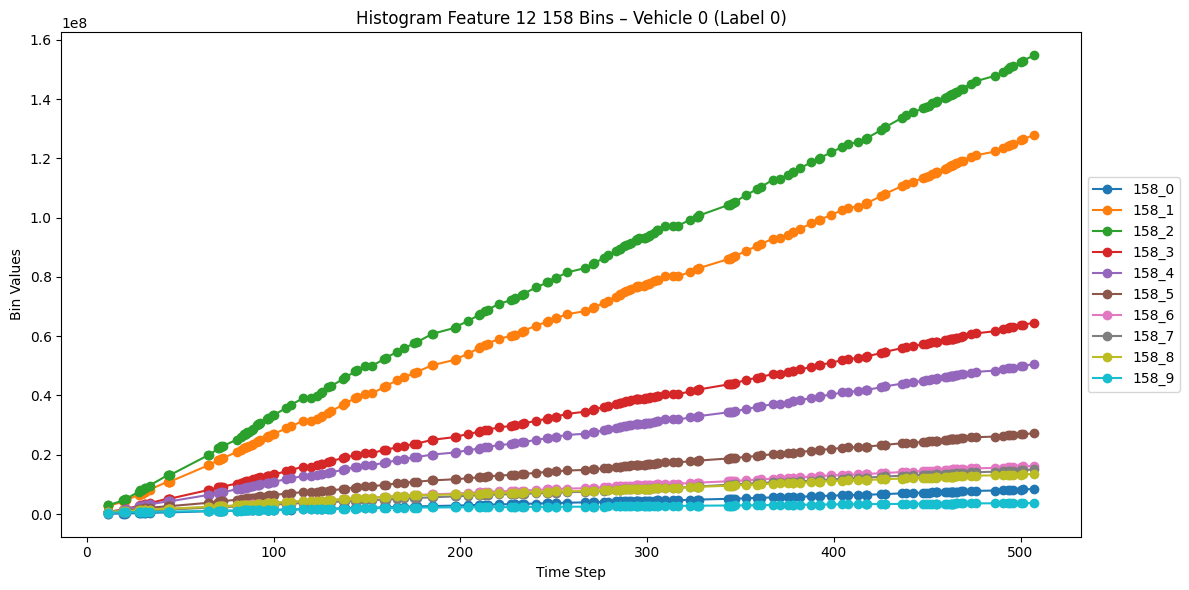

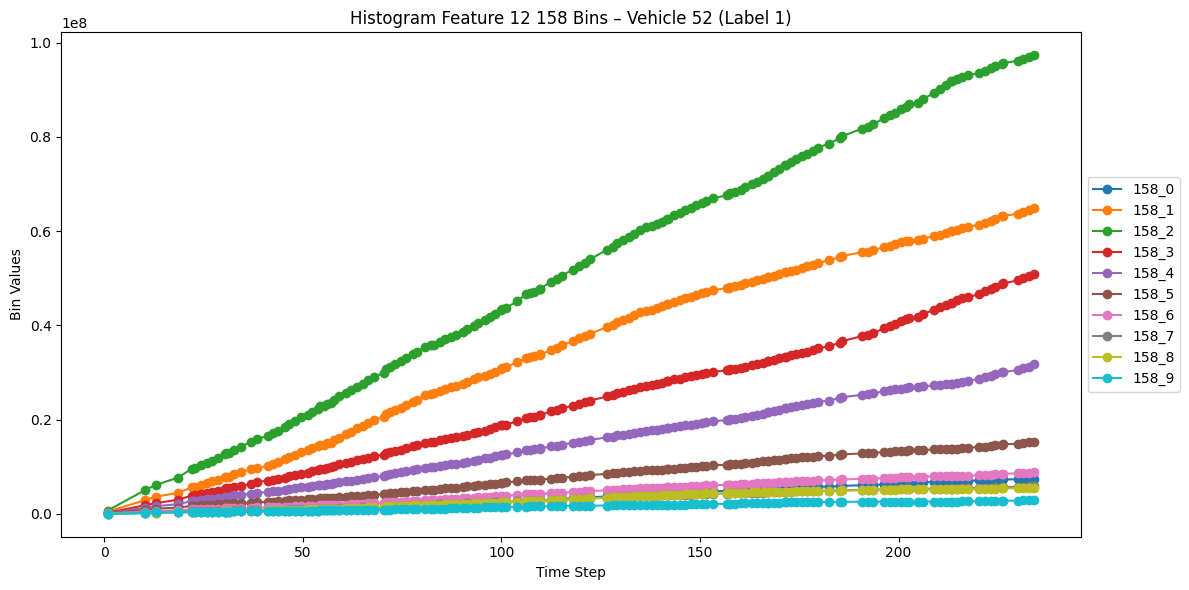

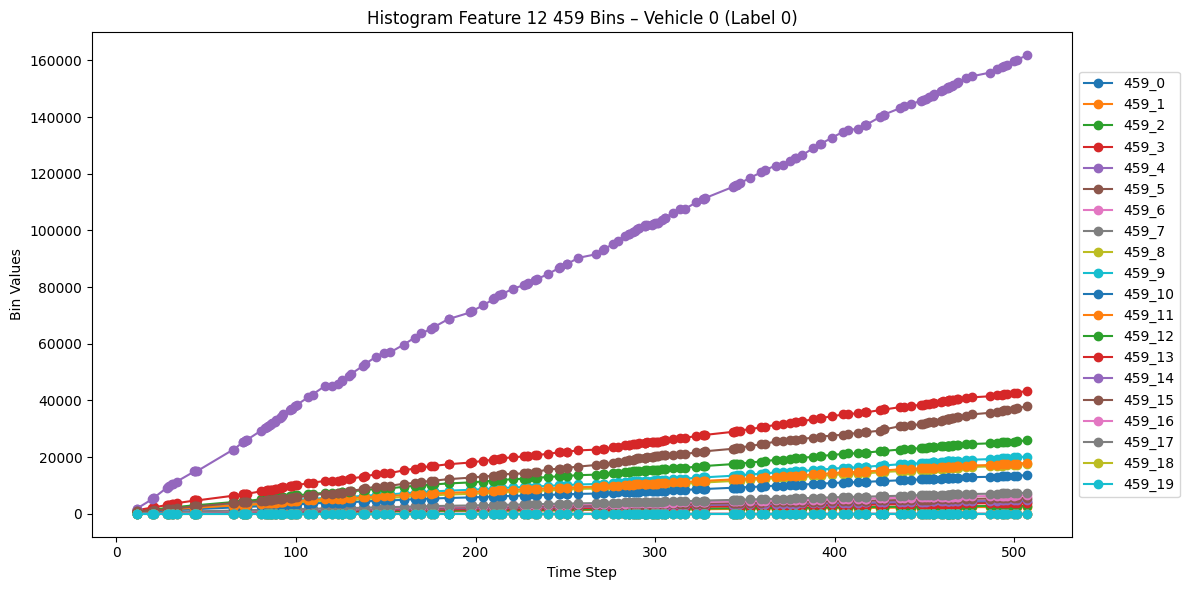

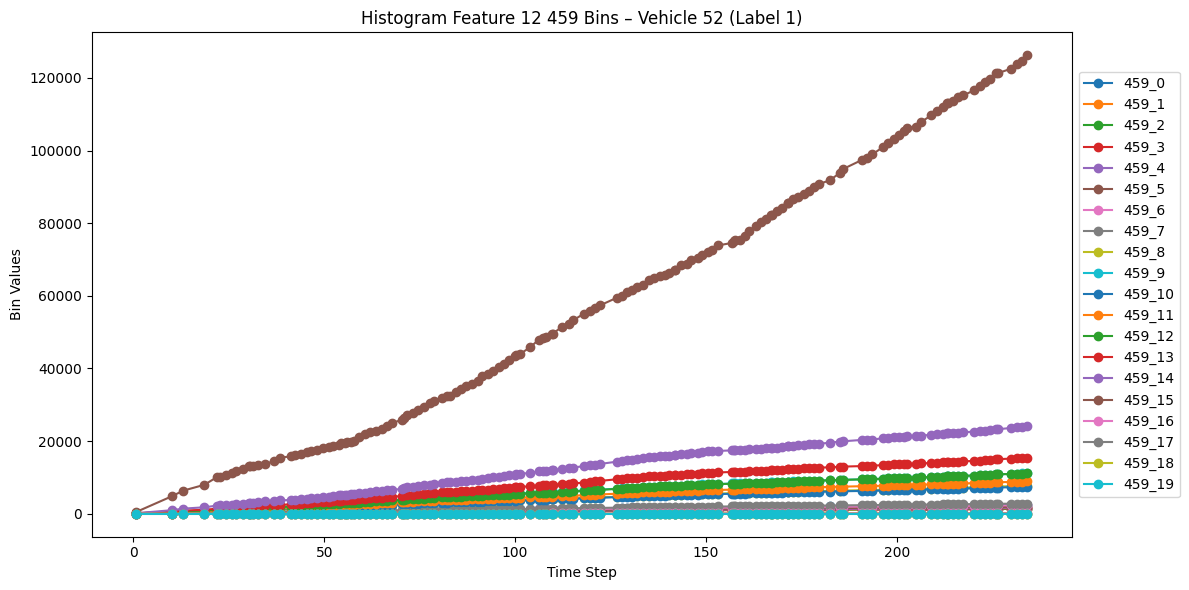

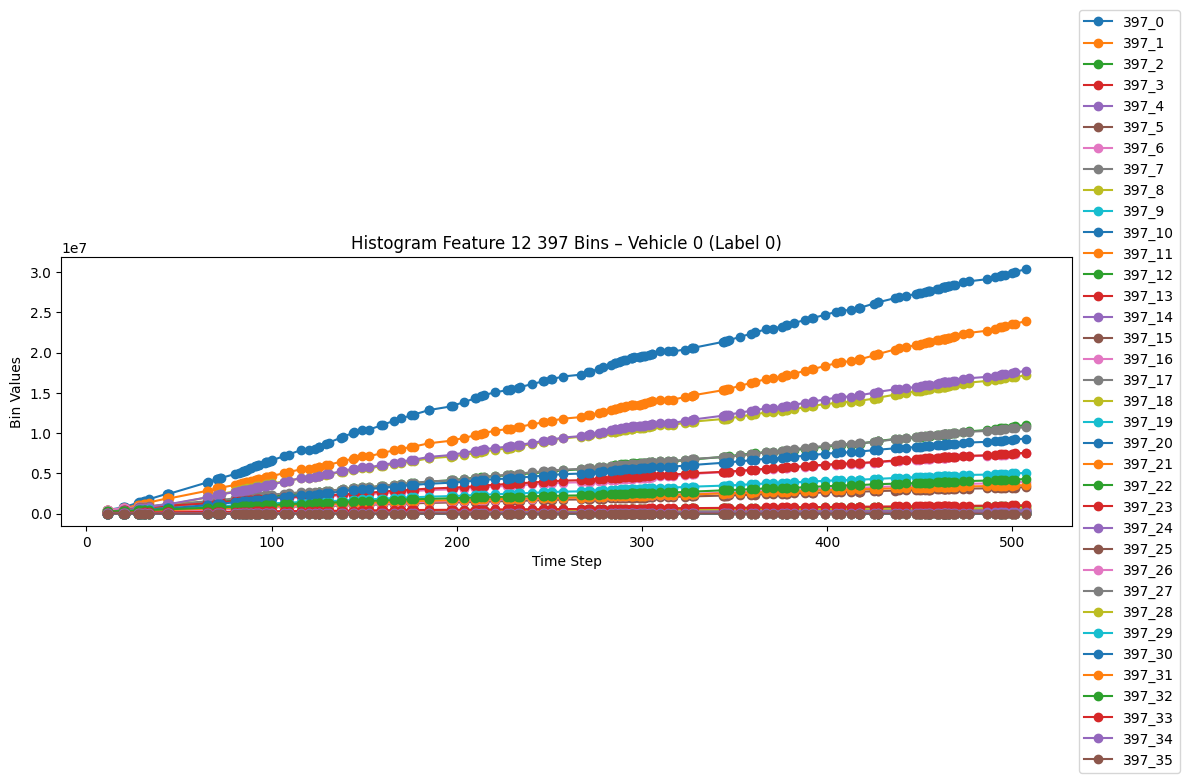

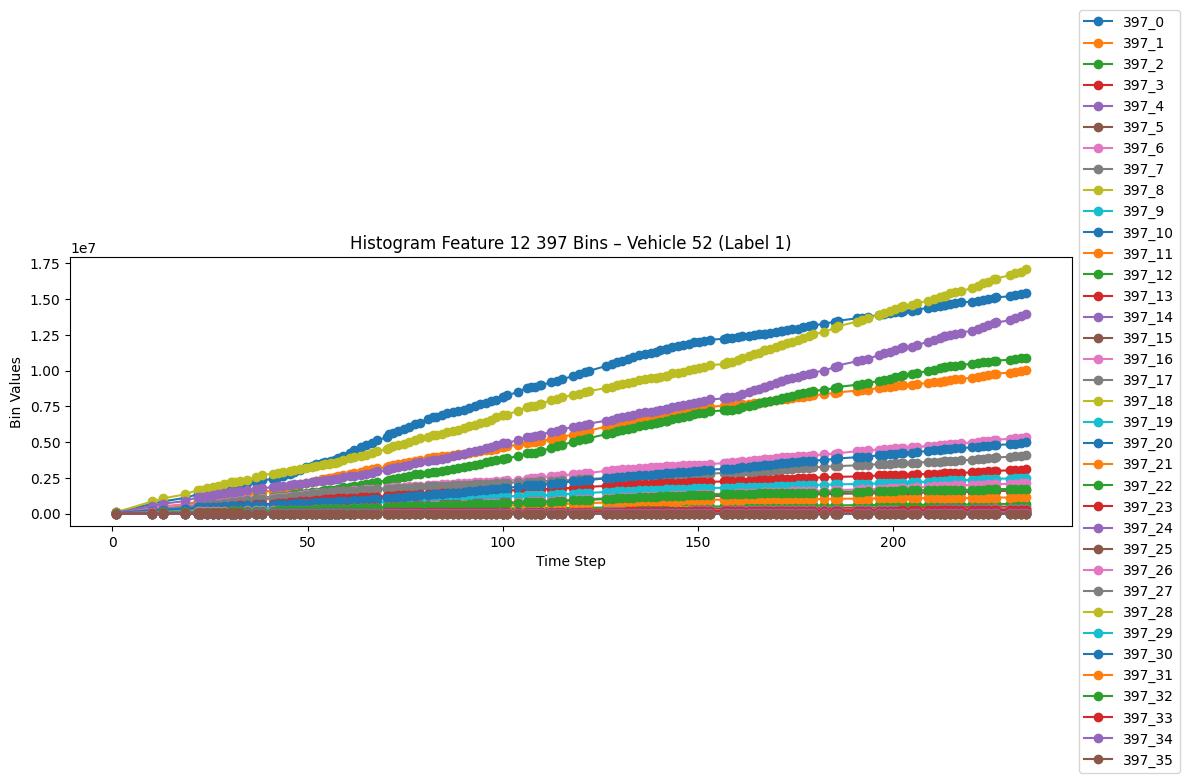

In [78]:
histogram_data_columns = [167, 272, 291, 158, 459, 397]
for variable_id in histogram_data_columns:
    plot_histogram_feature_bins_over_time(
        readout_df=readouts_train,
        label_df=tte_train_df,
        variable_id=str(variable_id)
    )

#### Analyse der kontinuierlichen Werten

##### Zeitverlauf


In [79]:
def plot_continuous_features_for_labels(
    readout_df: pd.DataFrame,
    label_df: pd.DataFrame,
    variable_ids: list,
    label_column: str = "in_study_repair"
) -> None:
    """
    Plots continuous readout features over time for one vehicle from each label class (0 and 1).

    Args:
        readout_df (pd.DataFrame): DataFrame containing continuous sensor features with columns 'vehicle_id' and 'time_step'.
        label_df (pd.DataFrame): DataFrame containing the label information including 'vehicle_id' and the class label column.
        variable_ids (list): List of continuous variable column names to plot (e.g., ["171_0", "666_0", ...]).
        label_column (str): Name of the column in label_df that contains the class labels (default: "in_study_repair").

    Returns:
        None. Displays two line plots, one per class.
    """
    # Merge beide DataFrames auf vehicle_id
    merged_df = pd.merge(readout_df, label_df[['vehicle_id', label_column]], on='vehicle_id', how='inner')

    # Für jede Klasse (0 und 1) ein Fahrzeug auswählen und plotten
    for label in sorted(merged_df[label_column].unique()):
        # Ein zufälliges Fahrzeug mit diesem Label auswählen
        vehicle_id = merged_df[merged_df[label_column] == label]["vehicle_id"].iloc[0]
        vehicle_data = merged_df[merged_df["vehicle_id"] == vehicle_id].sort_values("time_step")

        # Plot vorbereiten
        plt.figure(figsize=(10, 6))
        for var in variable_ids:
            if var in vehicle_data.columns:
                plt.plot(
                    vehicle_data["time_step"], 
                    vehicle_data[var], 
                    marker="o", 
                    label=var
                )

        plt.title(f"Non-Histogram Features of Vehicle {vehicle_id} (Label {label})")
        plt.xlabel("Time Step")
        plt.ylabel("Feature Values")
        plt.legend()
        plt.tight_layout()
        plt.show()


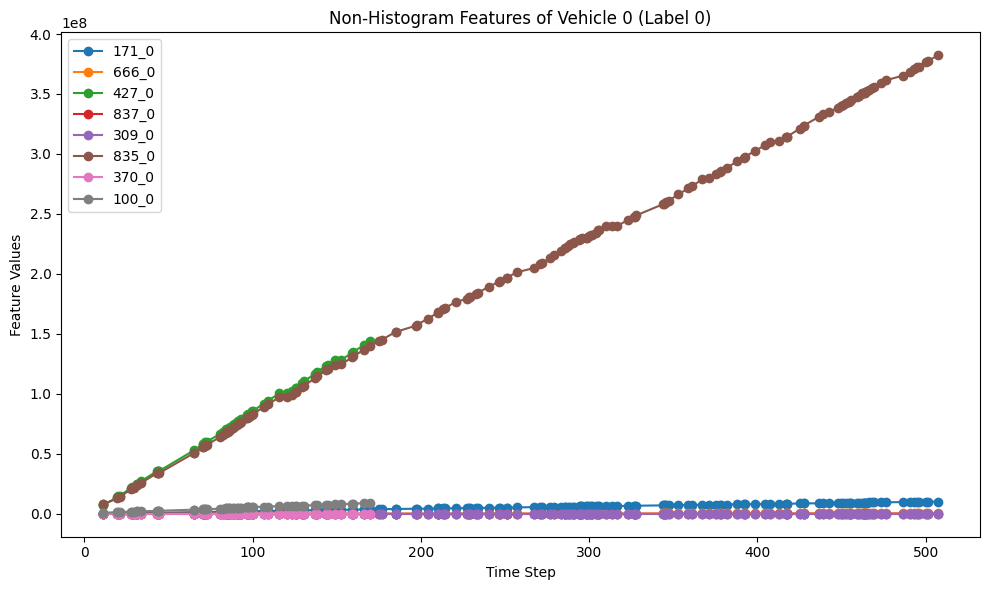

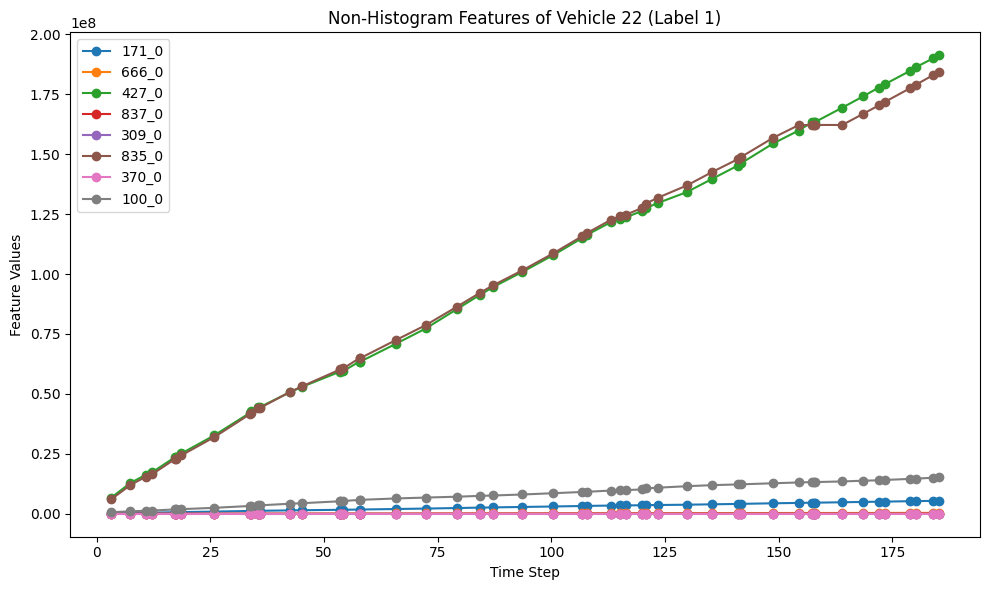

In [80]:
numeric_variable_ids = ["171_0", "666_0", "427_0", "837_0", "309_0", "835_0", "370_0", "100_0"]

plot_continuous_features_for_labels(
    readout_df=readouts_train,
    label_df=tte_train_df,
    variable_ids=numeric_variable_ids
)


##### Statistische Kennzahlen

In [81]:
def summarize_continuous_features(raw_data: pd.DataFrame, variable_ids: list) -> pd.DataFrame:
    """
    Berechnet statistische Kennzahlen für kontinuierliche Merkmale eines DataFrames.

    Args:
        raw_data (dict): Dictionary mit Schlüsseln wie 'train', 'val', 'test', die jeweils ein Dict mit DataFrames enthalten.
        variable_ids (list): Liste von Spalten, die analysiert werden sollen.

    Returns:
        pd.DataFrame: DataFrame mit statistischen Kennzahlen pro Spalte.
                      Enthält: Mittelwert, Median, Standardabweichung, Varianz,
                      Min, Max, Interquartilsabstand (IQR), Quantile (25%, 75%), Anzahl NaN.
    """

    combined_df = pd.concat(
        [
            raw_data[split]["readouts"][variable_ids].assign(split=split)
            for split in ["train", "validation", "test"]
            if "readouts" in raw_data[split]
        ],
        axis=0
    )

    # Statistische Zusammenfassung
    summary = combined_df[variable_ids].describe().T
    summary["iqr"] = summary["75%"] - summary["25%"]
    summary["missing_values"] = combined_df[variable_ids].isnull().sum()

    return summary


In [82]:
summary_df = summarize_continuous_features(raw_data, numeric_variable_ids)
print("Statistische Zusammenfassung der kontinuierlichen Merkmale:")
print(summary_df)


Statistische Zusammenfassung der kontinuierlichen Merkmale:
           count          mean           std    min         25%          50%  \
171_0  1516819.0  3.325156e+06  2.718588e+06   15.0   1226985.0    2677035.0   
666_0  1516759.0  1.401391e+05  1.729517e+05    0.0     32210.5      84514.0   
427_0  1508125.0  1.270064e+08  1.001664e+08  605.0  49700840.0  104643934.0   
837_0  1516760.0  4.838761e+04  8.695322e+04    0.0      2928.0      16637.0   
309_0  1516767.0  9.673024e+03  6.006761e+04    0.0        42.0        505.0   
835_0  1516765.0  1.468338e+08  1.134819e+08    0.0  60100487.0  122578803.0   
370_0  1508131.0  5.964429e+06  1.788769e+07    0.0         0.0          0.0   
100_0  1508127.0  1.284244e+07  1.253583e+07  981.0   4301412.0    9374994.0   

               75%           max          iqr  missing_values  
171_0    4798447.5  3.048960e+07    3571462.5               0  
666_0     183032.5  5.886459e+06     150822.0              60  
427_0  181710828.0  1.04645

##### Analyse der Datenqualität

In [83]:
def run_ge_quality_analysis_legacy(raw_data: dict, variable_ids: list[str]) -> pd.DataFrame:
    """
    Einfache Datenqualitätsanalyse ohne Great Expectations.
    
    Args:
        raw_data (dict): Dictionary mit Splits ('train', 'val', 'test') und jeweils 'readouts'-DataFrames.
        variable_ids (list[str]): Liste mit Spaltennamen der kontinuierlichen Variablen.
    
    Returns:
        pd.DataFrame: Qualitätsmetriken als DataFrame.
    """
    # Readout-Daten zusammenführen
    combined_df = pd.concat([
        raw_data["train"]["readouts"],
        raw_data["validation"]["readouts"],
        raw_data["test"]["readouts"]
    ], ignore_index=True)

    # Nur numerische Spalten extrahieren
    df_subset = combined_df[variable_ids]
    
    quality_metrics = []
    
    for column in variable_ids:
        if column in df_subset.columns:
            col_data = df_subset[column]
            quality_metrics.append({
                'column': column,
                'total_count': len(col_data),
                'null_count': col_data.isnull().sum(),
                'null_percentage': round((col_data.isnull().sum() / len(col_data)) * 100, 2),
                'unique_count': col_data.nunique(),
                'data_type': str(col_data.dtype),
                'min_value': round(col_data.min(), 4) if not col_data.isnull().all() else None,
                'max_value': round(col_data.max(), 4) if not col_data.isnull().all() else None,
                'mean_value': round(col_data.mean(), 4) if not col_data.isnull().all() else None,
                'std_value': round(col_data.std(), 4) if not col_data.isnull().all() else None,
                'has_outliers': bool((col_data < col_data.quantile(0.01)).any() or 
                                   (col_data > col_data.quantile(0.99)).any()) if not col_data.isnull().all() else False,
                'data_quality_score': round(100 - (col_data.isnull().sum() / len(col_data)) * 100, 1)
            })
    
    return pd.DataFrame(quality_metrics)

In [84]:
df_ge_results = run_ge_quality_analysis_legacy(raw_data, numeric_variable_ids)
display(df_ge_results)

,column,total_count,null_count,null_percentage,unique_count,data_type,min_value,max_value,mean_value,std_value,has_outliers,data_quality_score
0,171_0,1516819,0,0.00,538959,float64,15.0,3.048960e+07,3.325156e+06,2.718588e+06,True,100.0
1,666_0,1516819,60,0.00,411015,float64,0.0,5.886459e+06,1.401391e+05,1.729517e+05,True,100.0
2,427_0,1516819,8694,0.57,1489422,float64,605.0,1.046455e+09,1.270064e+08,1.001664e+08,True,99.4
3,837_0,1516819,59,0.00,232708,float64,0.0,6.524252e+06,4.838761e+04,8.695322e+04,True,100.0
4,309_0,1516819,52,0.00,93729,float64,0.0,1.118641e+07,9.673024e+03,6.006761e+04,True,100.0
5,835_0,1516819,54,0.00,1504216,float64,0.0,1.022947e+09,1.468338e+08,1.134819e+08,True,100.0
6,370_0,1516819,8688,0.57,437700,float64,0.0,2.824418e+08,5.964429e+06,1.788769e+07,True,99.4
7,100_0,1516819,8692,0.57,1457704,float64,981.0,2.802376e+08,1.284244e+07,1.253583e+07,True,99.4


##### Korrelationsmatrix

In [85]:
def plot_correlation_matrix(df: pd.DataFrame, columns: list) -> None:
    """
    Plottet eine Korrelationsmatrix für die angegebenen numerischen Spalten des DataFrames.

    Args:
        df (pd.DataFrame): Der DataFrame mit den numerischen Spalten.
        columns (list): Liste der Spaltennamen, für die die Korrelation berechnet werden soll.
        

    Returns:
        None. Zeigt eine Heatmap mit Korrelationswerten.
    """
    # Korrelation berechnen
    corr = df[columns].corr()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5)
    plt.title("Korrelation der kontinuierlichen Sensorwerte")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


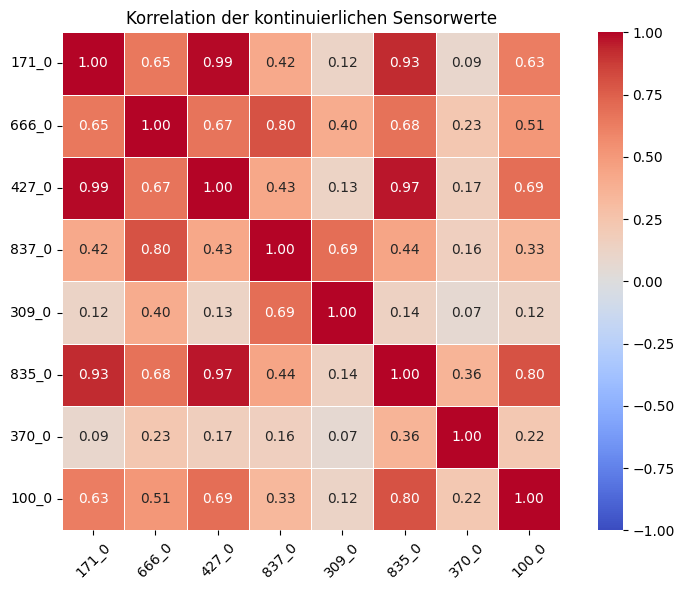

In [86]:
plot_correlation_matrix(df=readouts_train, 
                        columns=numeric_variable_ids)

#### Zeitverlauf der Readout Daten

In [87]:


def plot_vehicle_readout_timelines(
    readout_df: pd.DataFrame,
    tte_df: pd.DataFrame,
    n_healthy: int = 5,
    n_failed: int = 5
) -> None:
    """
    Plots the reading timelines of selected vehicles from the training dataset.
    Healthy and failed vehicles are displayed with markers indicating their last reading.

    Args:
        readout_df (pd.DataFrame): DataFrame with operational readouts including vehicle_id and time_step.
        tte_df (pd.DataFrame): DataFrame with time-to-event labels including vehicle_id, 
            length_of_study_time_step, and in_study_repair.
        n_healthy (int, optional): Number of healthy vehicles to display. Defaults to 5.
        n_failed (int, optional): Number of failed vehicles to display. Defaults to 5.
    
    Returns:
        None: Shows a matplotlib plot of the readout timelines.
    """
    # Auswahl der Fahrzeug-IDs
    healthy_ids = tte_df[tte_df["in_study_repair"] == 0].sample(n=n_healthy, random_state=42)["vehicle_id"].tolist()
    failed_ids = tte_df[tte_df["in_study_repair"] == 1].sample(n=n_failed, random_state=42)["vehicle_id"].tolist()
    selected_ids = healthy_ids + failed_ids

    # Subset Readout-Daten
    subset_df = readout_df[readout_df["vehicle_id"].isin(selected_ids)]

    # Mapping von vehicle_id zu y-Achsen-Position (für Klarheit)
    id_to_y = {vid: i for i, vid in enumerate(selected_ids)}

    plt.figure(figsize=(12, 5))

    # Zeichne alle Beobachtungen (blaue Punkte)
    for vid, group in subset_df.groupby("vehicle_id"):
        y_pos = id_to_y[vid]
        plt.scatter(group["time_step"], [y_pos] * len(group), color='navy', s=10)

    # Zeichne Marker für letzte Beobachtung (grün für gesund, rot für defekt)
    for vid in selected_ids:
        y_pos = id_to_y[vid]
        tte_row = tte_df[tte_df["vehicle_id"] == vid].iloc[0]
        end_time = tte_row["length_of_study_time_step"]
        label = tte_row["in_study_repair"]
        marker_color = 'green' if label == 0 else 'red'
        plt.scatter(end_time, y_pos, color=marker_color, s=50, marker='o', edgecolors='black', zorder=5)

    # Achsen
    plt.yticks(ticks=range(len(selected_ids)), labels=selected_ids)
    plt.xlabel("Time step")
    plt.ylabel("Vehicle ID")
    plt.title("Readings of Vehicles and Repair Status")

    # Manuelle Legende
    legend_elements = [
        Line2D([0], [0], marker='o', color='navy', label='Readout', markersize=6, linestyle=''),
        Line2D([0], [0], marker='o', color='green', label='Healthy (0)', markeredgecolor='black', markersize=8, linestyle=''),
        Line2D([0], [0], marker='o', color='red', label='Failed (1)', markeredgecolor='black', markersize=8, linestyle='')
    ]
    plt.legend(handles=legend_elements, loc="best")

    plt.tight_layout()
    plt.show()


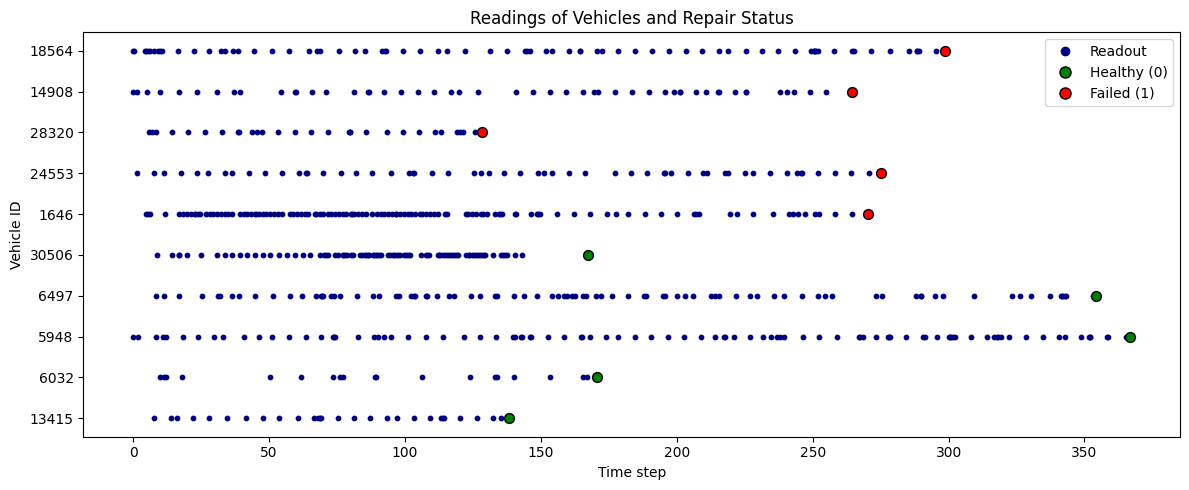

In [88]:
plot_vehicle_readout_timelines(
    readout_df=readouts_train,
    tte_df=tte_train_df)

### Analyse der Fehlenden Werte

#### Fehlende Werte im zeitverlauf

In [89]:
def plot_missing_value_trend_per_time(raw_data: dict) -> None:
    """
    Visualisiert für jeden DataFrame in raw_data den Verlauf fehlender Werte über den Zeitverlauf.
    Für jede Spalte wird der Anteil an fehlenden Werten pro time_step berechnet (in Prozent).

    Args:
        raw_data (dict): Dictionary mit Schlüsseln wie 'train', 'val', 'test', die jeweils wiederum ein Dict enthalten
                         (z. B. mit 'readouts', 'spec', 'labels', etc.), wobei jeder Eintrag ein DataFrame ist.

    Returns:
        None. Gibt entweder eine Grafik oder eine Textmeldung aus.
    """
    for split_name, dataset in raw_data.items():
        for key, df in dataset.items():
            # if "time_step" not in df.columns:
            #     print(f"⏩ Überspringe '{split_name} – {key}': keine Zeitinformation vorhanden.")
            #     continue

            if not df.isnull().values.any():
                print(f"✅ Keine fehlenden Werte in '{split_name} – {key}'")
                continue

            # Prozentuale fehlende Werte pro time_step
            missing_per_time = df.groupby("time_step").apply(
                lambda x: x.isnull().mean().mean() * 100
            )

            # Plot
            plt.figure(figsize=(10, 4))
            plt.plot(missing_per_time.index, missing_per_time.values, color="darkblue")
            plt.title(f"Fehlende Werte in {split_name} – {key} über Zeit")
            plt.xlabel("time_step")
            plt.ylabel("Anteil fehlender Werte (%)")
            plt.grid(True, linestyle="--", alpha=0.4)
            plt.tight_layout()
            plt.show()


✅ Keine fehlenden Werte in 'test – labels'


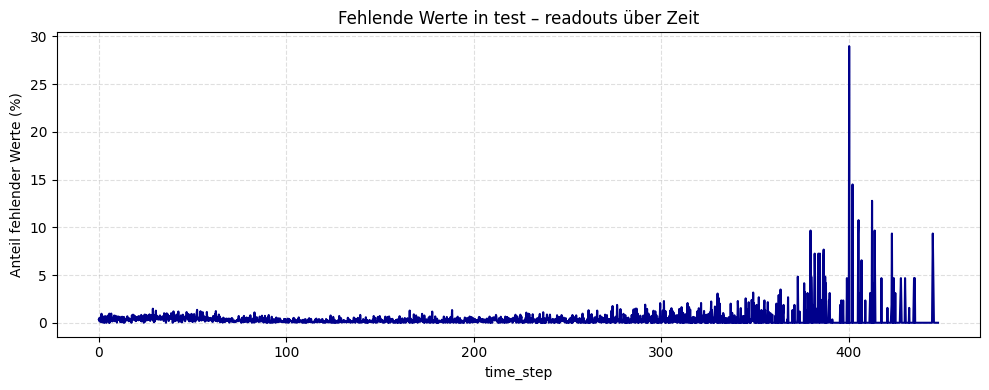

✅ Keine fehlenden Werte in 'test – spec'
✅ Keine fehlenden Werte in 'train – tte'


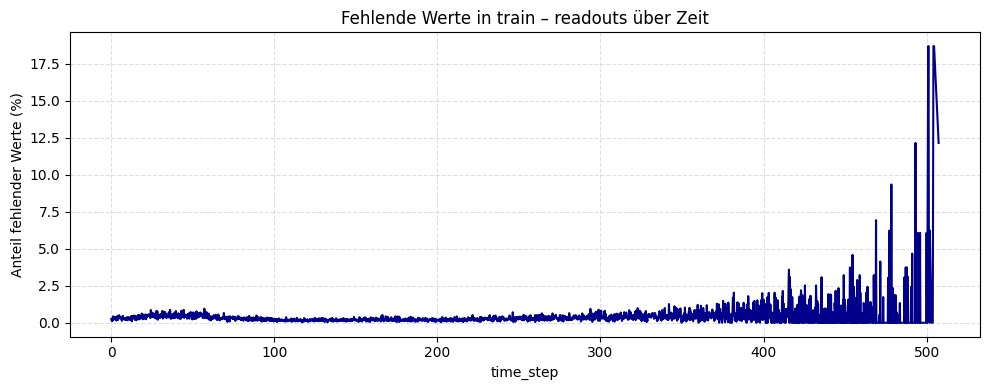

✅ Keine fehlenden Werte in 'train – spec'
✅ Keine fehlenden Werte in 'validation – labels'


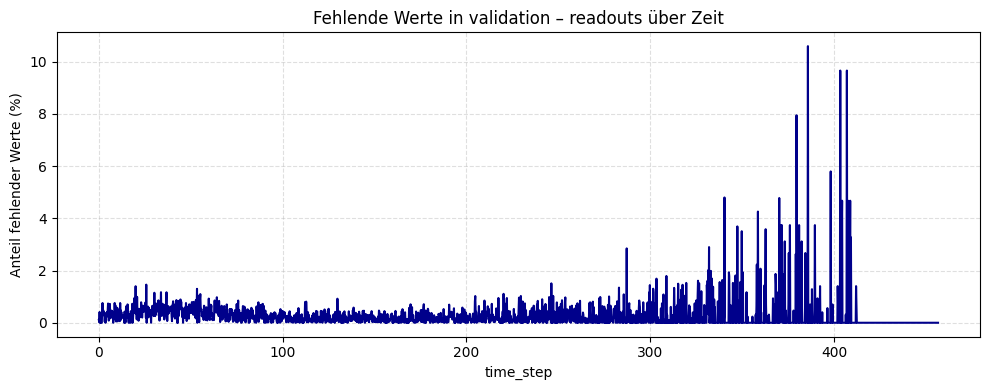

✅ Keine fehlenden Werte in 'validation – spec'


In [90]:
plot_missing_value_trend_per_time(raw_data)

#### Fehlende Werte pro Spalte

In [91]:
def missing_value_table_per_column(raw_data: dict) -> pd.DataFrame:
    """
    Erstellt eine transponierte Tabelle mit dem prozentualen Anteil fehlender Werte pro Spalte und Split (train/val/test).
    Die Spaltennamen der Readouts werden zu Zeilen, die Splits zu Spalten.

    Args:
        raw_data (dict): Dictionary mit Schlüsseln wie 'train', 'val', 'test', die jeweils wiederum ein Dict enthalten
                         (z. B. mit 'readouts', 'spec', 'labels', etc.), wobei jeder Eintrag ein DataFrame ist.

    Returns:
        pd.DataFrame: Tabelle mit Zeilen = Spaltennamen, Spalten = Splits, Werte = % fehlender Werte.
    """
    result_rows = []

    for split_name, dataset in raw_data.items():
        readout_df = dataset.get("readouts")
        if readout_df is None:
            continue

        if not readout_df.isnull().values.any():
            continue

        missing_percent = readout_df.isnull().mean() * 100
        result_rows.append(missing_percent.rename(split_name))

    if not result_rows:
        return pd.DataFrame()

    return pd.concat(result_rows, axis=1)  # Spalten = Splits, Zeilen = Feature-Namen


In [92]:

pd.set_option("display.max_rows", None)  # Alle Zeilen anzeigen
pd.set_option("display.max_columns", None)  # Alle Spalten anzeigen

missing_value_table_per_column(raw_data)

,test,train,validation
vehicle_id,0.000000,0.000000,0.000000
time_step,0.000000,0.000000,0.000000
171_0,0.000000,0.000000,0.000000
666_0,0.004038,0.003564,0.006115
427_0,0.517311,0.570626,0.644152
837_0,0.003533,0.003475,0.006625
167_0,0.441102,0.254977,0.252768
167_1,0.441102,0.254977,0.252768
167_2,0.441102,0.254977,0.252768
167_3,0.441102,0.254977,0.252768


##### Größe und Anzhal der Fehlenden Daten

In [93]:
def generate_readout_summary_table(raw_data: dict) -> pd.DataFrame:
    """
    Erstellt eine Zusammenfassungstabelle über die Readout-Daten in Train, Validation und Test.
    
    Args:
        raw_data (dict): Dictionary mit den Daten unter den Keys 'train', 'val', 'test', jeweils mit 'readouts'-DataFrames.
    
    Returns:
        pd.DataFrame: Übersichtstabelle mit Metriken pro Split.
    """
    results = []


    for split in raw_data.keys():
        df = raw_data[split]['readouts']

        num_vehicles = df['vehicle_id'].nunique()
        num_readouts = len(df)
        avg_readouts_per_vehicle = df.groupby('vehicle_id').size().mean()
        missing_values = df.isnull().sum().sum()
        total_values = df.size
        missing_percentage = missing_values / total_values * 100

        results.append({
            "#vehicles": num_vehicles,
            "#readouts": num_readouts,
            "#readouts per vehicle (average)": round(avg_readouts_per_vehicle),
            "#total values": total_values,
            "#missing values": missing_values,
            "%missing values": f"{missing_percentage:.5f}%"
        })

    # Statische Prozentwerte für Fahrzeuge (laut Paper)
    df_result = pd.DataFrame(results, index=["Train set", "Validation set", "Test set"]).T
    df_result.loc["%vehicles"] = ["70%", "15%", "15%"]
    df_result = df_result[["Train set", "Validation set", "Test set"]]

    return df_result


In [94]:
summary_df = generate_readout_summary_table(raw_data)

print("Readout Summary Table:")
display(summary_df)


Readout Summary Table:


,Train set,Validation set,Test set
#vehicles,5045,23550,5046
#readouts,198140,1122452,196227
#readouts per vehicle (average),39,48,39
#total values,21200980,120102364,20996289
#missing values,66403,354634,60339
%missing values,0.31321%,0.29528%,0.28738%
%vehicles,70%,15%,15%
